In [1]:
import os
import copy
import re
import psignifit as ps
import glob
# import pickle as pkl
import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats
import pandas as pd
import importlib

import scipy as sp
import itertools
import matplotlib as mpl
import matplotlib.patches as patches
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 
# /n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit  

In [2]:
import functools3 as p3

In [3]:
from psignifit import getSigmoidHandle as getSig

In [4]:
#set_plot_params()
visual_areas, area_colors = p3.set_threecolor_palette() 

In [5]:
%matplotlib notebook

In [6]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [7]:
src_data_dir = os.path.join(aggregate_dir, 'data-stats', 'tmp_data')
dfns = glob.glob(os.path.join(src_data_dir, '*.pkl'))
dfns

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/results.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/R.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/AUC.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/AUC_single.pkl']

In [8]:
src_datafile = os.path.join(src_data_dir, dfns[0])
src_datafile

'/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl'

# Load source data

In [9]:
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
# D.keys()

DATA = D['DATA']
sdata = D['sdata']
SDF = D['SDF']
selective_df = D['selective_df']
del D

In [10]:
DATA[DATA['visual_area']=='Li']['datakey'].unique()


array(['20190327_JC073_fov1', '20191018_JC113_fov1',
       '20190319_JC067_fov1', '20190322_JC073_fov1',
       '20190315_JC070_fov1', '20190607_JC091_fov1',
       '20190602_JC091_fov1', '20190321_JC070_fov1',
       '20190614_JC091_fov1', '20190612_JC099_fov1',
       '20190314_JC070_fov1', '20190617_JC099_fov1',
       '20190316_JC070_fov1', '20191111_JC120_fov1',
       '20190609_JC099_fov1', '20190320_JC067_fov1',
       '20190422_JC076_fov1', '20190606_JC091_fov1',
       '20191105_JC117_fov1'], dtype=object)

In [11]:
DATA.shape

(4542744, 7)

In [12]:
data_id = os.path.splitext(os.path.split(src_datafile)[-1])[0]


In [13]:
sdata[sdata['datakey']=='20190512_JC083_fov1']

experiment visual_area              datakey animalid            fov  \
124        rfs          Lm  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   
125   gratings          Lm  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   
126      blobs          Lm  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   
127     retino          Lm  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   
192        rfs          V1  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   
193   gratings          V1  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   
194      blobs          V1  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   
195     retino          V1  20190512_JC083_fov1    JC083  FOV1_zoom2p0x   

      session  fovnum  
124  20190512       1  
125  20190512       1  
126  20190512       1  
127  20190512       1  
192  20190512       1  
193  20190512       1  
194  20190512       1  
195  20190512       1

In [14]:
# sd_file = os.path.join(aggregate_dir, 'dataset_info_assigned.pkl')
# with open(sd_file, 'wb') as f:
#     pkl.dump(sdata, f, protocol=2)

# Params

In [15]:
#### Set params
single_eff=True


sigmoid='gauss'
allow_negative=False
sigmoid_dir = '%s_reverse' % sigmoid if not allow_negative else sigmoid
print(sigmoid_dir)
param = 'morphlevel'
 
class_a=0
class_b=106

criterion = 0.7

fitopts = p3.default_options()


gauss_reverse


# Output dir

In [16]:
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'neurometric_curves', 'psignifit', 'fit_%s' % sigmoid_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
os.listdir(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse


['auc_allcells-crit-0.70.svg',
 'fitparams_allcells-crit-0.70_meansbycell_validparams.svg',
 'fitparams_allcells-crit-0.70_meansbycell_.svg',
 'avg_all_roi_curves_by_area_ploteach__.svg',
 'average_area_curves_splitEff_allcells.svg',
 'average_area_curves_combined_.svg',
 'average_area_curves_splitEff_.svg']

###### Check 1 fov

In [17]:
# import shutil
# aucfiles = glob.glob(os.path.join(rootdir, 'JC*', '2019*', 'FOV*', 'combined_blobs_static', 'traces',
#                       '%s*' % traceid, 'neurometric', 'fits', 'split_arousal'))
# len(aucfiles)

In [18]:
importlib.reload(p3)

<module 'functools3' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/functools3.py'>

In [32]:
va = 'V1'
dk = '20190616_JC097_fov1'
sdf = SDF[dk].copy()
rid=217
rfits, results = p3.load_fitparams(dk, roi_list=[rid], return_dicts=True,
                                 allow_negative=allow_negative, sigmoid=sigmoid, split_pupil=False)


In [27]:

# traceid_dir = p3.get_tracedir_from_datakey(dk)
# roi_fit_fns = glob.glob(os.path.join(traceid_dir, 'neurometric', 'fits', sigmoid_dir, 'rid*.pkl'))
# len(roi_fit_fns)

51

In [20]:
# results={}
# r_=[]
# for rfn in roi_fit_fns:
#     with open(rfn, 'rb') as f:
#         rd = pkl.load(f)
#     if not isinstance(rd, dict):
#         continue
#     if 'results' not in rd.keys():
#         print("Incorect results file. Found keys: %s" % str(rd.keys()))
#         continue
#     rid = p3.get_rid_from_str(rfn)
#     results[rid] = rd['results']
#     r_.append(rd['pars'])
# rfits2 = pd.concat(r_)


In [33]:
rfits[rfits['cell']==217]

threshold     width        lambda  gamma           eta     slope       thr  \
0   1.146000  1.094396  7.259429e-08    0.5  1.515871e-09  0.599602  1.146000   
1   1.059993  0.245168  8.916742e-08    0.5  9.878073e-04  2.676533  1.059993   
2   0.805331  1.040515  1.172572e-09    0.5  1.112275e-08  0.630651  0.805331   
3   0.999102  1.875598  1.416762e-09    0.5  1.572677e-09  0.349863  0.999102   
4   1.150523  0.239112  4.286470e-08    0.5  1.947834e-01  2.744323  1.150523   

  visual_area              datakey  cell  size Eff  
0          V1  20190616_JC097_fov1   217  10.0   0  
1          V1  20190616_JC097_fov1   217  20.0   0  
2          V1  20190616_JC097_fov1   217  30.0   0  
3          V1  20190616_JC097_fov1   217  40.0   0  
4          V1  20190616_JC097_fov1   217  50.0   0

# Load aggregate AUC

In [25]:
importlib.reload(p3)

<module 'functools3' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/functools3.py'>

In [19]:
#### Load AUC 
AUC = p3.load_aggregate_AUC(param=param, allow_negative=allow_negative,
                          selective_only=False, selective_df=None, single_eff=single_eff)
if 'object' not in AUC.columns:
    AUC['object'] = 'M'
    AUC.loc[AUC['morphlevel']<53, 'object'] = 'A'
    AUC.loc[AUC['morphlevel']>53, 'object'] = 'B'


   cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0   113        0      0  0.590000           0  10.0  106        30   
1   113        1      1  0.543333          14  10.0  106        30   
2   113        2      2  0.596667          27  10.0  106        30   
3   113        3      3  0.523333          40  10.0  106        30   
4   113        4      4  0.644444          53  10.0  106        30   

  visual_area              datakey object  
0          Li  20190315_JC070_fov1      A  
1          Li  20190315_JC070_fov1      A  
2          Li  20190315_JC070_fov1      A  
3          Li  20190315_JC070_fov1      A  
4          Li  20190315_JC070_fov1      M  
... reversing


In [50]:
#### Only select cells with min. response > crit
criterion = 0.7

sdf = SDF['20191006_JC110_fov1'].copy()
morphlevels = [i for i in sorted(sdf['morphlevel'].unique()) if i!=-1]
anchors_ = [i for ii in [morphlevels[0:2], morphlevels[-2:]] for i in ii]


pAUC = AUC[(AUC['morphlevel'].isin(anchors_)) & (AUC['AUC']>=criterion)].copy()
# pAUC = pd.concat([g for (va, dk, c), g in AUC.groupby(['visual_area', 'datakey', 'cell']) \
#                   if g['AUC'].max()>=criterion])

print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(pAUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


Total N cells fit:
             datakey  cell
visual_area               
Li               644   644
Lm              1101  1101
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               197   197
Lm               404   404
V1               612   612


In [ ]:
best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
assert len(pass_cells)==len(best_sz_per_cell)
if len(best_sz_per_cell)==0:
    print("****[%s, %s] no cells." % (va, dk))

best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])


# Load aggregate fits

In [22]:
pAUC['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

In [51]:
print("Allow negative? %s" % allow_negative)
missing={}
r_=[]
for (va, dk), g in pAUC.groupby(['visual_area', 'datakey']):
    #print(va, dk)
    curr_fits, curr_miss = p3.load_fitparams(dk, roi_list=g['cell'].unique(),
                                 allow_negative=allow_negative, sigmoid=sigmoid, split_pupil=False,
                                 return_dicts=False, return_missing=True)
    r_.append(curr_fits)
    if len(curr_miss)>0:
        missing[(va, dk)] = curr_miss
    
roifits = pd.concat(r_).reset_index(drop=True)


Allow negative? False


In [105]:
missing

{('Lm', '20190322_JC073_fov1'): [119,
  142,
  151,
  170,
  173,
  175,
  179,
  181,
  184,
  195,
  197,
  206,
  303,
  305],
 ('Lm', '20190422_JC076_fov1'): [115, 140, 142, 168, 172, 175, 178],
 ('V1', '20190504_JC078_fov1'): [21, 23, 24, 25, 57, 82, 86, 87, 110, 263],
 ('V1', '20190508_JC083_fov1'): [197, 209, 220],
 ('V1', '20190509_JC078_fov1'): [51, 52, 83, 283],
 ('V1', '20190512_JC083_fov1'): [248, 250, 255, 260, 294, 305, 318, 325, 334],
 ('V1', '20190517_JC083_fov1'): [178, 184, 197, 199, 200, 205, 209]}

In [106]:
curr_fits

threshold     width        lambda  gamma           eta     slope  \
0     1.148927  0.239190  3.368943e-09    0.5  1.116405e-05  2.743428   
1     1.002569  1.774122  3.915820e-09    0.5  6.380594e-09  0.369874   
2     1.135284  0.239146  1.092944e-07    0.5  1.872705e-05  2.743933   
3     1.121078  0.241436  1.402996e-06    0.5  7.628948e-08    2.7179   
4     1.098729  0.724185  1.462606e-07    0.5  4.193947e-09  0.906124   
..         ...       ...           ...    ...           ...       ...   
115   1.200416  1.015888  9.831569e-09    0.5  8.188306e-09  0.645939   
116   1.100361  0.242714  1.354580e-06    0.5  5.630876e-08  2.703589   
117   1.120211  0.242345  1.560125e-06    0.5  8.735395e-08  2.707708   
118   1.053124  0.243846  8.883561e-08    0.5  6.966965e-04  2.691051   
119   1.014240  1.997241  1.377580e-09    0.5  2.000138e-08  0.328554   

          thr visual_area              datakey  cell  size  Eff  
0    1.148927          V1  20191006_JC110_fov1    12  10.0    0  
1    1.002569          V1  20191006_JC110_fov1    12  20.0    0  
2    1.135284          V1  20191006_JC110_fov1    12  30.0    0  
3    1.121079          V1  20191006_JC110_fov1    12  40.0    0  
4    1.098729          V1  20191006_JC110_fov1    12  50.0    0  
..        ...         ...                  ...   ...   ...  ...  
115  1.200416          V1  20191006_JC110_fov1   380  10.0  106  
116  1.100361          V1  20191006_JC110_fov1   380  20.0  106  
117  1.120211          V1  20191006_JC110_fov1   380  30.0  106  
118  1.053124          V1  20191006_JC110_fov1   380  40.0  106  
119   1.01424          V1  20191006_JC110_fov1   380  50.0  106  

[120 rows x 12 columns]

In [107]:
print(selective_df[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               326   326
Lm               636   636
V1               892   892


In [108]:
selective_only=False
selective_str = 'selective' if selective_only else "allcells"

if selective_only:
    print("... getting SELECTIVE only")
    s_=[]
    for (va, dk), g in pAUC.groupby(['visual_area', 'datakey']):
        curr_cells_auc = g['cell'].unique()

        curr_cells_sel = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)]['cell'].unique()
        sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
        s_.append(g[g['cell'].isin(sel_and_auc)])

    pSEL = pd.concat(s_, axis=0).reset_index(drop=True)

else:
    pSEL = pAUC.copy()
    
print(pSEL[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               197   197
Lm               404   404
V1               612   612


In [109]:
ncells_pass = pAUC.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()

In [110]:
meanAUC = pAUC.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
meanAUC.head()

visual_area              datakey  cell  Eff  level_1  index       AUC  \
0          Li  20190315_JC070_fov1   182  106     36.0   44.0  0.702222   
1          Li  20190315_JC070_fov1   183  106     26.0   23.0  0.775556   
2          Li  20190315_JC070_fov1   187  106     26.0   23.0  0.751111   
3          Li  20190315_JC070_fov1   191  106      7.5    6.5  0.715000   
4          Li  20190315_JC070_fov1   222  106     26.0   23.0  0.718889   

   morphlevel  size  n_trials  
0         0.0  50.0      30.0  
1       106.0  30.0      30.0  
2       106.0  30.0      30.0  
3        99.0  10.0      30.0  
4       106.0  30.0      30.0

<IPython.core.display.Javascript object>


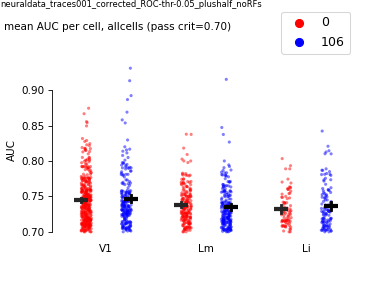

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse auc_allcells-crit-0.70


In [111]:
object_colors = {'A': 'r', 'B': 'b', 0:'r', 106: 'b'}
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots(figsize=(5,4), dpi=100)
sns.stripplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax, zorder=-1,
             dodge=0.5, palette=object_colors, alpha=0.5,size=3, order=visual_areas)

sns.pointplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax,
             join=False, dodge=0.5, color='k', markers='_', order=visual_areas,
             zorder=-1, scale=2)

ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, offset=4, bottom=True)
ax.set_xlabel('')

fig.text(0.01, 0.9, 'mean AUC per cell, %s (pass crit=%.2f)' % (selective_str, criterion))

p3.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1,1), loc='lower right')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.8)
p3.label_figure(fig, data_id)

figname = 'auc_%s-crit-%.2f' % (selective_str, criterion)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [112]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse'

In [113]:
psign_pars = ['threshold', 'width', 'lambda', 'gamma','eta']
parnames = copy.copy(psign_pars)
parnames.extend(['thr', 'slope'])
parnames

['threshold', 'width', 'lambda', 'gamma', 'eta', 'thr', 'slope']

In [114]:
roifits.shape

(5795, 12)

In [115]:
roifits.dropna().shape

(5443, 12)

In [116]:
onefit = pd.concat([g for (va, dk, ci), g in roifits.dropna().drop_duplicates()\
                    .groupby(['visual_area', 'datakey', 'cell']) \
                        if len(g['Eff'].unique())==1])

print(onefit[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
for p in parnames:
    onefit[p] = onefit[p].astype(float)

             datakey  cell
visual_area               
Li               197   197
Lm               384   384
V1               574   574


In [117]:
onefit.head()

threshold     width        lambda  gamma           eta     slope       thr  \
0   1.161844  0.989751  1.765294e-06    0.5  3.610233e-09  0.662994  1.161845   
1   1.078971  2.079057  1.714409e-04    0.5  3.116086e-09  0.315516  1.079243   
2   1.161541  1.371901  4.925858e-09    0.5  2.442768e-08  0.478316  1.161541   
3   1.096776  0.242886  1.004714e-07    0.5  1.226719e-07  2.701686  1.096776   
4   1.094934  1.256412  6.288922e-09    0.5  2.894787e-08  0.522282  1.094934   

  visual_area              datakey  cell  size  Eff  
0          Li  20190315_JC070_fov1   182  10.0  106  
1          Li  20190315_JC070_fov1   182  20.0  106  
2          Li  20190315_JC070_fov1   182  30.0  106  
3          Li  20190315_JC070_fov1   182  40.0  106  
4          Li  20190315_JC070_fov1   182  50.0  106

In [118]:
for p in parnames:
    roifits[p] = roifits[p].astype(float)

In [119]:
rfits = onefit.copy()
# passfits = rfits[(rfits['threshold']>=0) & (rfits['threshold']<=106)
#                   & (rfits['lambda']>0) & (rfits['width']<=106*1.5)]
meanfits = onefit.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
meanfits.head()

print(meanfits[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               197   197
Lm               384   384
V1               574   574


In [120]:
# meanfits_filt = meanfits[(meanfits['threshold']>=0) & (rfits['threshold']<=1)
#                   & (meanfits['lambda']>0) & (meanfits['width']<=1.5)]

meanfits_filt = meanfits[(meanfits['lambda']>0.0005) & (meanfits['eta']>0.0005)].copy()
print(meanfits_filt[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li                 1     1
Lm                 5     5
V1                 8     8


<IPython.core.display.Javascript object>


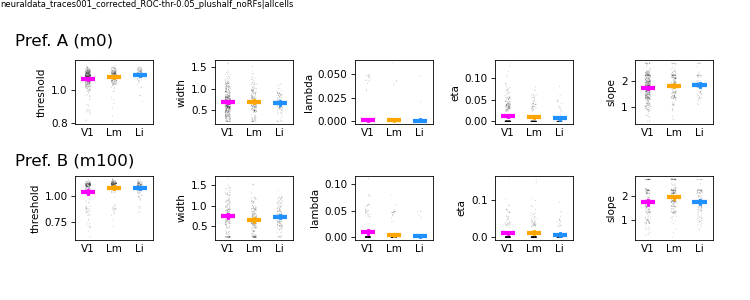

PARAM: threshold -----------------------------------------
                 count   mean    std    min    25%    50%    75%    max
visual_area Eff                                                        
Li          0     81.0  1.095  0.038  0.932  1.082  1.100  1.119  1.143
            106  116.0  1.079  0.063  0.846  1.060  1.098  1.118  1.161
Lm          0    193.0  1.080  0.046  0.812  1.062  1.089  1.107  1.151
            106  191.0  1.085  0.079  0.711  1.085  1.109  1.126  1.172
V1          0    393.0  1.070  0.049  0.815  1.056  1.079  1.097  1.167
            106  181.0  1.042  0.119  0.607  1.021  1.097  1.117  1.162
PARAM: width -----------------------------------------
                 count   mean    std    min    25%    50%    75%    max
visual_area Eff                                                        
Li          0     81.0  1.095  0.038  0.932  1.082  1.100  1.119  1.143
            106  116.0  1.079  0.063  0.846  1.060  1.098  1.118  1.161
Lm          0    193.0

In [121]:
filter_params=False
filter_str = 'validparams' if filter_params else ''

plotf = meanfits_filt.copy() if filter_params else meanfits.copy()


plot_params = ['threshold', 'width', 'lambda', 'eta','slope']

fig, axn = pl.subplots(2, len(plot_params), figsize=(len(plot_params)*2, 4))
for pi, p in enumerate(plot_params):
    ax=axn[0, pi]
    print("PARAM: %s -----------------------------------------" % p)
    print(plotf.groupby(['visual_area', 'Eff'])['threshold'].describe().round(3))
    
    sns.stripplot(y=p, data=plotf[plotf['Eff']==0], x='visual_area', ax=ax,
                 order=visual_areas, color='k', alpha=0.2, size=1, zorder=-1)
    sns.pointplot(y=p, data=plotf[plotf['Eff']==0], x='visual_area', ax=ax,
                 order=visual_areas, palette=area_colors, markers='_', scale=2, zorder=1)
    
    ax=axn[1, pi]
    sns.stripplot(y=p, data=plotf[plotf['Eff']==106], x='visual_area', ax=ax,
                 order=visual_areas, color='k', alpha=0.2, size=1, zorder=-1)
    sns.pointplot(y=p, data=plotf[plotf['Eff']==106], x='visual_area', ax=ax,
                 order=visual_areas, palette=area_colors, markers='_', scale=2, zorder=1)
    
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

fig.text(0.02, 0.85, 'Pref. A (m0)', fontsize=16)
fig.text(0.02, 0.45, 'Pref. B (m100)', fontsize=16)

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'fitparams_%s-crit-%.2f_meansbycell_%s' % (selective_str, criterion, filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


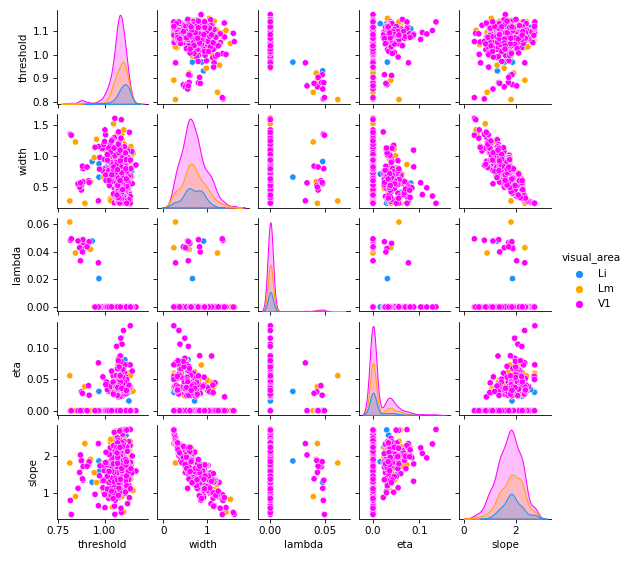

In [122]:


sns.pairplot(plotf[plotf['Eff']==0], hue='visual_area', vars=plot_params, height=1.5,
            palette=area_colors)

<IPython.core.display.Javascript object>


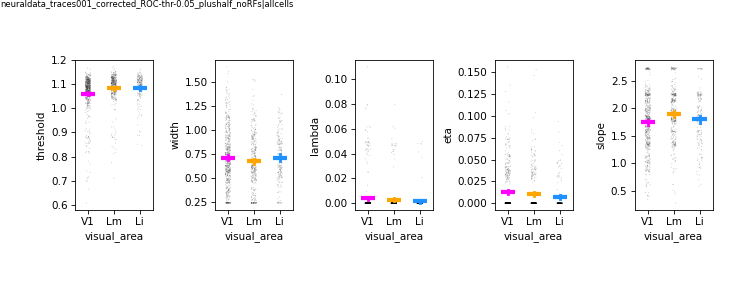

PARAM: threshold -----------------------------------------
             count   mean    std    min    25%    50%    75%    max
visual_area                                                        
Li           197.0  1.085  0.054  0.846  1.071  1.099  1.119  1.161
Lm           384.0  1.083  0.064  0.711  1.069  1.099  1.118  1.172
V1           574.0  1.061  0.079  0.607  1.052  1.082  1.106  1.167
PARAM: width -----------------------------------------
             count   mean    std    min    25%    50%    75%    max
visual_area                                                        
Li           197.0  0.710  0.252  0.241  0.534  0.706  0.886  1.368
Lm           384.0  0.673  0.279  0.238  0.492  0.650  0.855  1.523
V1           574.0  0.711  0.293  0.240  0.516  0.682  0.902  1.657
PARAM: lambda -----------------------------------------
             count   mean    std  min  25%  50%  75%    max
visual_area                                                
Li           197.0  0.002  0.0

In [124]:
filter_params=False
filter_str = 'validparams' if filter_params else ''

plotf = meanfits_filt.copy() if filter_params else meanfits.copy()


plot_params = ['threshold', 'width', 'lambda', 'eta','slope']

fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*2, 4))
for pi, p in enumerate(plot_params):
    ax=axn[pi]
    print("PARAM: %s -----------------------------------------" % p)
    print(plotf.groupby(['visual_area'])[p].describe().round(3))
    
    sns.stripplot(y=p, data=plotf, x='visual_area', ax=ax,
                 order=visual_areas, color='k', alpha=0.2, size=1, zorder=-1)
    sns.pointplot(y=p, data=plotf, x='visual_area', ax=ax,
                 order=visual_areas, palette=area_colors, markers='_', scale=2, zorder=1)
    
# ax.tick_params(which='both', axis='x', size=0)
# ax.set_xlabel('')

# fig.text(0.02, 0.85, 'Pref. A (m0)', fontsize=16)
# fig.text(0.02, 0.45, 'Pref. B (m100)', fontsize=16)

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.3, top=0.8, wspace=0.8, hspace=0.8)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'fitparams_combineAB_%s-crit-%.2f_meansbycell_%s' % (selective_str, criterion, filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


# Plot neurometric curves

In [125]:
print(allow_negative)
sig='gauss'
opts = p3.default_options()
opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)
opts['widthalpha'] = .05


f_=[]
for (va, dk, ci, sz), g in onefit.groupby(['visual_area', 'datakey', 'cell', 'size']):
    eff = int(g['Eff'].unique())
    opts['sigmoidName'] = 'neg_%s' % sigmoid if (eff==0 and allow_negative) else sig
    fh = getSig.getSigmoidHandle(opts)
    fvs = p3.get_fit_values(g, fh, xmin=0, xmax=1, npoints=50)
    f_.append(fvs)
    
fitvs = pd.concat(f_)

False


In [126]:
g

threshold     width        lambda  gamma           eta     slope  \
5794    1.01424  1.997241  1.377580e-09    0.5  2.000138e-08  0.328554   

          thr visual_area              datakey  cell  size  Eff  
5794  1.01424          V1  20191006_JC110_fov1   380  50.0  106

In [127]:
def plot_thres_mean_sem(fpars, ax, thresh_height=0.55, ymin=0.5, lw=1, ls='-',
                       grouper=['Eff'], group_colors={0: 'r', 1: 'b'}, fill_alpha=0.2, ci='sem'):
    
    #ax.set_ylim([ax.get_ylim()[0], 1])

    mean_thr = fpars.groupby(grouper)['threshold'].mean()
    if ci=='ci':
        sem_thr = fpars.groupby(grouper)['threshold'].apply(p3.get_empirical_ci)
    else:
        sem_thr = fpars.groupby(grouper)['threshold'].sem()
    
    grp_ = fpars[grouper].unique()
    for i in grp_:
        print(i, group_colors[i])

    for eff, ecol in group_colors.items():
        thr_ = mean_thr.loc[eff]
        sd_ = sem_thr.loc[eff]
        #print(a_, s_, thr_hi, sd_hi)
        
        x0 = (sd_[0], ymin) if ci=='ci' else (thr_-sd_, ymin) # point of origin.
        bar_width = sd_[1]-sd_[0] if ci=='ci' else sd_*2.
        ax.plot([thr_, thr_], [ymin, thresh_height], color=ecol, lw=lw, linestyle=ls)
        ax.add_patch(patches.Rectangle(xy=x0, width=bar_width,
                    height=thresh_height-ymin, linewidth=0, color=ecol, fill=True, alpha=fill_alpha) )

<IPython.core.display.Javascript object>


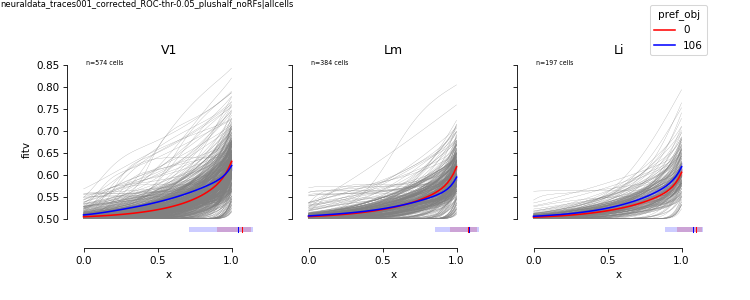

106 b
0 r
0 r
106 b
106 b
0 r
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse avg_all_roi_curves_by_area_ploteach__


In [131]:
plot_each_cell=True

plot_str = 'ploteach' if plot_each_cell else ''

object_colors={0: 'r', 106: 'b'}

mean_fpars_by_cell = onefit.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
mean_fitvs_by_cell = fitvs.groupby(['visual_area', 'datakey', 'cell', 'Eff', 'x']).mean().reset_index()

fig, axn = pl.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for va, fv in mean_fitvs_by_cell.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = axn[ai]
    
    if plot_each_cell:
        for (dk, c, eff), gg in fv.groupby(['datakey', 'cell', 'Eff']):
            ax.plot(gg['x'], gg['fitv'], color='gray', lw=0.2)

    sns.lineplot(x='x', y='fitv', hue='Eff', data=fv, ax=ax, palette=object_colors)
    ax.set_title(va)
    
    fpars = mean_fpars_by_cell[(mean_fpars_by_cell.visual_area==va)].copy()
    
    thresh_height=0.48 if plot_each_cell else 0.505 
    ymin=0.47 if plot_each_cell else 0.5 
    text_loc = 0.85 if plot_each_cell else 0.65
    plot_thres_mean_sem(fpars, ax, thresh_height=thresh_height, ymin=ymin, lw=1, ls='-',
                       grouper='Eff', group_colors=object_colors, fill_alpha=0.2, ci='ci')
        
    ax.legend_.remove()
    ncells = fpars.shape[0]
    ax.text(0.02, text_loc, 'n=%i cells' % ncells, fontsize=6)
    
sns.despine(trim=True, offset=8)    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)
axn[-1].legend(bbox_to_anchor=(1,1), loc='lower right', title='pref_obj')

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'avg_all_roi_curves_by_area_%s__%s' % (plot_str,filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


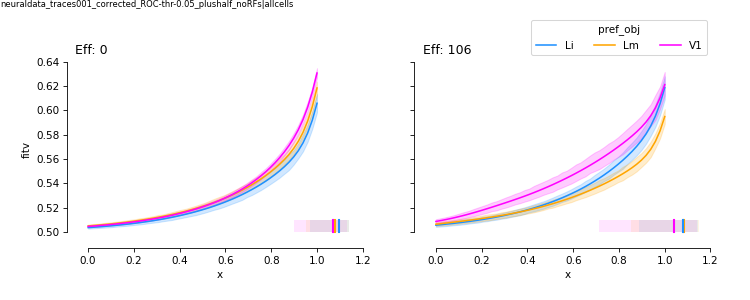

Li dodgerblue
Lm orange
V1 magenta
Li dodgerblue
Lm orange
V1 magenta
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse average_area_curves_splitEff_


In [132]:

fig, axn = pl.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
for ai, (eff, fv) in enumerate(mean_fitvs_by_cell.groupby(['Eff'])):
    ax = axn[ai]
    
    sns.lineplot(x='x', y='fitv', hue='visual_area', data=fv, ax=ax, palette=area_colors)
    ax.set_title('Eff: %i' % eff, loc='left')
    
    fpars = mean_fpars_by_cell[(mean_fpars_by_cell['Eff']==eff)].copy()
    plot_thres_mean_sem(fpars, ax, thresh_height=0.51, ymin=0.5, lw=2, ls='-',
                       grouper='visual_area', group_colors=area_colors, fill_alpha=0.1, ci='ci')

    ax.legend_.remove()

sns.despine(trim=True, offset=8)    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)
axn[-1].legend(bbox_to_anchor=(1,1), loc='lower right', title='pref_obj', ncol=3)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'average_area_curves_splitEff_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


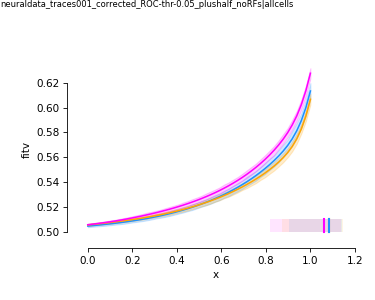

Li dodgerblue
Lm orange
V1 magenta
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse average_area_curves_combined_


In [134]:

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True)

sns.lineplot(x='x', y='fitv', hue='visual_area', data=mean_fitvs_by_cell, ax=ax, palette=area_colors)


fpars = mean_fpars_by_cell.copy()
plot_thres_mean_sem(fpars, ax, thresh_height=0.51, ymin=0.5, lw=2, ls='-',
                   grouper='visual_area', group_colors=area_colors, fill_alpha=0.1, ci='ci')

ax.legend_.remove()

sns.despine(trim=True, offset=8)    
pl.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.8)
axn[-1].legend(bbox_to_anchor=(1,1), loc='lower right', title='pref_obj', ncol=3)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'average_area_curves_combined_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [516]:
va='V1'
dk = '20191006_JC110_fov1'
roifit[(roifit['visual_area']==va) & (rfit.datakey==dk)]['cell'].unique()


NameError: name 'roifit' is not defined

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


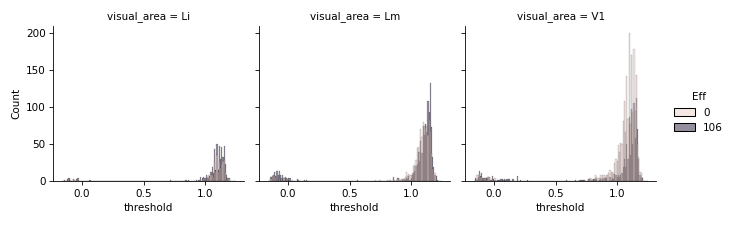

In [69]:
sns.displot(x='threshold', hue='Eff', data=onefit, col='visual_area', ax=ax, height=3)


In [317]:

def group_fit_vals(g, opts=None, allow_negative=True, xmin=0, xmax=1):
    eff = int(g['Eff'].unique())
    if opts is None:
        opts = p3.default_options()
    opts['sigmoidName'] = 'neg_%s' % sig if (eff==0 and allow_negative) else sig
    fh = getSig.getSigmoidHandle(opts)
    fvs = p3.get_fit_values(g, fh, xmin=xmin, xmax=xmax, npoints=50)
    
    return fvs

def plot_roi_fit(fparams, grouper='size', ax=None, 
                 plot_threshold=True, ymin=0.5, yheight=0.1, col='k',
                cmap='cubehelix'):
    if ax is None:
        fig, ax = pl.subplots()
        
    if grouper is not None:
        curr_fvs = fparams.groupby(grouper).apply(group_fit_vals)
        vals = sorted(fparams[grouper].unique())
        cols = sns.color_palette(cmap, n_colors=len(vals))
        group_colors = dict((v, c) for v, c in zip(vals, cols))
    else:
        curr_fvs = group_fit_vals(fparams)
        col='k'
        group_colors=None
        
    sns.lineplot(x='x', y='fitv', hue=grouper, data=curr_fvs, ax=ax, palette=group_colors)
    
    if plot_threshold:
        if grouper is not None:
            for v, g in fparams.groupby(grouper):
                thr = float(g['threshold'].values)
                ax.plot([thr, thr], [ymin, ymin+yheight], color=group_colors[v])
        else:
            thr = float(fparams['threshold'].values)
            ax.plot([thr, thr], [ymin, ymin+yheight], color=col)
    
    #)
    sns.despine(offset=8, trim=True)
    
    return ax

In [325]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit'

In [326]:
curr_dst_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)

In [323]:
va='V1'
dk = '20191006_JC110_fov1'
rfits = roifits[(roifits.visual_area==va) & (roifits.datakey==dk)].copy()
print(rfits.shape)

rid=240
fparams = rfits[rfits['cell']==rid]
fparams

(155, 12)


threshold     width        lambda  gamma           eta     slope  \
6880   1.133696  1.170004  2.624277e-09    0.5  2.799685e-07  0.560854   
6881   1.098474  1.194989  5.882353e-09    0.5  3.888809e-08  0.549128   
6882   0.899865  2.074527  3.512068e-05    0.5  1.218568e-08  0.316292   
6883   0.859538  1.883427  2.751141e-09    0.5  1.561955e-08  0.348408   
6884   1.074169  0.242425  1.574938e-07    0.5  2.543757e-04  2.706828   

           thr visual_area              datakey  cell  size  Eff  
6880  1.133696          V1  20191006_JC110_fov1   240  10.0  106  
6881  1.098474          V1  20191006_JC110_fov1   240  20.0  106  
6882  0.899920          V1  20191006_JC110_fov1   240  30.0  106  
6883  0.859538          V1  20191006_JC110_fov1   240  40.0  106  
6884  1.074169          V1  20191006_JC110_fov1   240  50.0  106

In [324]:
opts = p3.default_options()
curr_fvs = fparams.groupby(['size']).apply(group_fit_vals, opts=opts)
curr_fvs.head()

x      fitv visual_area              datakey  cell  size  Eff
size                                                                        
10.0 0  0.000000  0.500359          V1  20191006_JC110_fov1   240  10.0  106
     1  0.020408  0.500437          V1  20191006_JC110_fov1   240  10.0  106
     2  0.040816  0.500530          V1  20191006_JC110_fov1   240  10.0  106
     3  0.061224  0.500641          V1  20191006_JC110_fov1   240  10.0  106
     4  0.081633  0.500774          V1  20191006_JC110_fov1   240  10.0  106

<IPython.core.display.Javascript object>


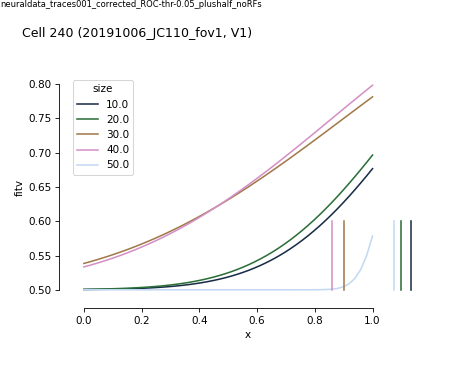

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples fitcurves_V1_20191006_JC110_fov1_rid240


In [327]:
fig, ax = pl.subplots(figsize=(6,5))
ax = plot_roi_fit(fparams, grouper='size', ax=ax, )


pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

p3.label_figure(fig, data_id)
fig.text(0.05, 0.9, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)

figname = 'fitcurves_%s_%s_rid%03d' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [328]:
data_id

'neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs'

In [329]:
    
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(sr, pPred)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals


In [330]:
def get_empirical_ci(stat, ci=0.95):
    p = ((1.0-ci)/2.0) * 100
    lower = np.percentile(stat, p) #max(0.0, np.percentile(stat, p))
    p = (ci+((1.0-ci)/2.0)) * 100
    upper = np.percentile(stat, p) # min(1.0, np.percentile(x0, p))
    #print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return lower, upper

In [331]:
fitopts = p3.default_options()
fitopts

{'expType': '2AFC', 'sigmoidName': 'gauss', 'threshPC': 0.5}

In [333]:
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(sr, pPred)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals


In [336]:
traceid_dir = p3.get_tracedir_from_datakey(dk)
roi_fit_fns = glob.glob(os.path.join(traceid_dir, 'neurometric', 'fits', sigmoid_dir, 'rid*.pkl'))
# print('%i of %i fit cells pass' % (len(g['cell'].unique()), len(roi_fit_fns)))
len(roi_fit_fns)

31

In [337]:
# R = {}
# for rfn in roi_fit_fns:
#     with open(rfn, 'rb') as f:
#         rd = pkl.load(f)

#     rid = int(os.path.splitext(os.path.split(rfn)[-1])[0][3:])
#     R[rid] = rd['results']

    
#print(va, dk)
curr_fits, R, curr_miss = p3.load_fitparams(dk, roi_list=None,
                             allow_negative=allow_negative, sigmoid=sigmoid, split_pupil=False,
                             return_dicts=True, return_missing=True)


In [339]:
len(R)

31

In [464]:
auc_ = auc_r[auc_r['size']==30]

opts = default_options()
opts['sigmoidName'] = 'neg_%s' % sig if int(auc_['Eff'].unique())<53 else sig
opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)

In [340]:

rid = 240
curr_sz = 40
res = R[rid][curr_sz]

d_resid, deviance, samples_d_resid, samples_d, r_vals = getDeviance(res, Nsamples=1000)
print(d_resid.shape, deviance.shape, samples_d_resid.shape, samples_d.shape)
print(deviance, d_resid)

(9,) () (1000, 9) (1000,)
2.6435016324150453 [-0.2090375   0.09217582  0.1834802   0.42973554  0.40993421  0.08335441
  1.01126741 -0.6236079  -0.88680796]


In [343]:
sizes = sorted(auc_r['size'].unique())

size_colors = dict((s, v) for s, v in zip(sizes, sns.color_palette('cubehelix', n_colors=len(sizes))))


In [345]:
assert deviance == np.sum(d_resid**2)
fit = res['Fit']
data = res['data']
pPred = fit[3] + (1-fit[2]-fit[3]) * res['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
data_r, data_p = spstats.pearsonr(pPred, d_resid)
ci_lo, ci_hi = get_empirical_ci(r_vals)

In [346]:
importlib.reload(ps.psigniplot)


<module 'psignifit.psigniplot' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [347]:
rid = 240
curr_r = R[rid]


In [350]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit'

In [355]:
if not os.path.exists(os.path.join(dst_dir, 'deviance')):
    os.makedirs(os.path.join(dst_dir, 'deviance'))

(9,) () (1000, 9) (1000,)
1.995711663213143 [-0.69096691 -0.18804522 -0.03923494  0.24559309  0.8142675   0.08956778
  0.43512237 -0.6525013  -0.36731006]


<IPython.core.display.Javascript object>


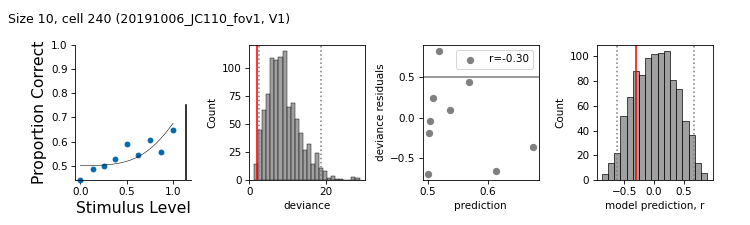

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
3.735790433773893 [-0.87921847 -1.05438767 -0.58055169  0.73699208 -0.29010952  0.67858965
 -0.08110184  0.18973758 -0.61936182]


<IPython.core.display.Javascript object>


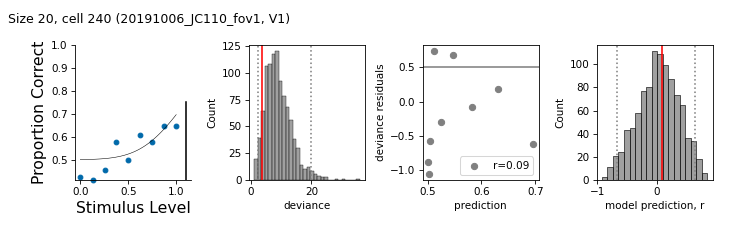

V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
7.532621413923643 [-0.44841316  0.23057787  0.34408608  1.50876179  0.91416372  0.77074596
 -1.52959173  0.23342915 -1.02943618]


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


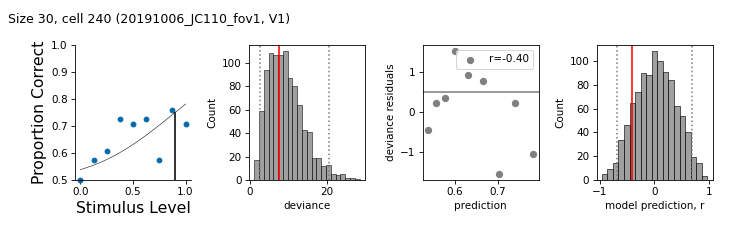

V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
2.6435016324150453 [-0.2090375   0.09217582  0.1834802   0.42973554  0.40993421  0.08335441
  1.01126741 -0.6236079  -0.88680796]


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


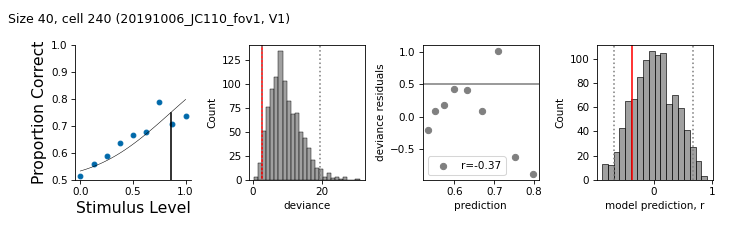

V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
12.990125167304953 [-1.03169219 -1.9333336   0.         -1.37844778 -1.72775002 -0.5225937
 -1.22321121 -1.23786806 -0.03243414]


<IPython.core.display.Javascript object>


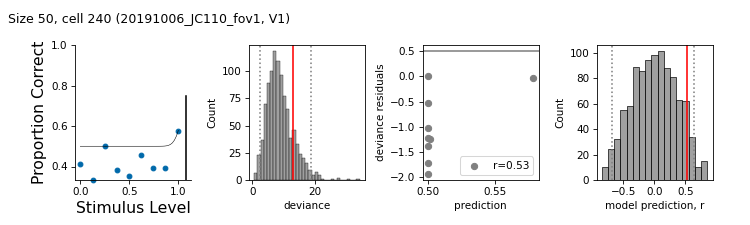

V1_20191006_JC110_fov1_rid240_deviance


In [356]:
for sz, auc_ in auc_r.groupby(['size']):
#auc_ = auc_r[auc_r['size']==sz]

    res = curr_r[sz]
    
    opts = p3.default_options()
    opts['sigmoidName'] = 'neg_%s' % sig if int(auc_['Eff'].unique())<53 else sig
    opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)

    d_resid, deviance, samples_d_resid, samples_d, r_vals = getDeviance(res, Nsamples=1000)
    print(d_resid.shape, deviance.shape, samples_d_resid.shape, samples_d.shape)
    print(deviance, d_resid)

    assert deviance == np.sum(d_resid**2)
    fit = res['Fit']
    data = res['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * res['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    data_r, data_p = spstats.pearsonr(pPred, d_resid)
    ci_lo, ci_hi = get_empirical_ci(r_vals)


    col='gray'
    thresh_height=0.5
    npoints=50

    fig,axn=pl.subplots(1,4, figsize=(10,3))
    ax=axn[0]
    ax = ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=True, lineWidth=0.5, plotAsymptote=False,
                                   thresh_height=None, npoints=npoints, extrapolLength=0, dataSize=5)

    ax=axn[1]
    sns.histplot(data=samples_d, ax=ax, color=col)
    ax.axvline(x=deviance, color='r')
    ax.set_xlabel('deviance')
    ci_lo, ci_hi = get_empirical_ci(samples_d)
    for ci in [ci_lo, ci_hi]:
        ax.axvline(x=ci, color=col, linestyle=':')
        
        
    ax=axn[2]
    ax.scatter(pPred, d_resid, label='r=%.2f' % data_r, c=col)
    ax.legend()
    ax.set_xlabel('prediction')
    ax.set_ylabel('deviance residuals')
    ax.axhline(y=0.5, color='gray')

    ax=axn[3]
    sns.histplot(data=r_vals, ax=ax, color=col)
    ci_lo, ci_hi = get_empirical_ci(r_vals)
    ax.axvline(x=data_r, color='r')
    for ci in [ci_lo, ci_hi]:
        ax.axvline(x=ci, color=col, linestyle=':')
    ax.set_xlabel('model prediction, r')

    pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

    fig.text(0.01, 0.9, 'Size %i, cell %i (%s, %s)' % (sz, rid, dk, va), fontsize=12)

    figname = '%s_%s_rid%03d_deviance' % (va, dk, rid)
    pl.savefig(os.path.join(dst_dir, 'deviance', '%s.svg' % figname))
    print(figname)

In [349]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples'

In [361]:
mean_params = roifits.groupby(['visual_area', 'datakey', 'cell', 'size']).mean().reset_index()
mean_params.shape

(6925, 11)

In [174]:
sorted(passAUC['size'].unique())

[10.0, 20.0, 30.0, 40.0, 50.0]

## Selectivity vs. biases

In [400]:
print("... getting SELECTIVE only")
s_=[]
for (va, dk), g in roifits.groupby(['visual_area', 'datakey']):
    curr_cells_auc = g['cell'].unique()

    curr_cells_sel = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)]['cell'].unique()
    sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
    s_.append(g[g['cell'].isin(sel_and_auc)])

pPAR = pd.concat(s_, axis=0).reset_index(drop=True)

pass_selective = [(v, k, r) for (v, k, r), g in pPAR.groupby(['visual_area', 'datakey', 'cell'])]


... getting SELECTIVE only


In [403]:
len(pass_selective)

1043

In [401]:
mean_par = pPAR.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
mean_par.shape

(1043, 12)

In [404]:
pSEL = pd.concat([g for (v, k, r), g in\
                            selective_df.groupby(['visual_area', 'datakey', 'cell']) \
                           if (v, k, r) in pass_selective])

mean_sel = pSEL.groupby(['visual_area', 'datakey', 'cell']).mean().reset_index()
mean_sel.shape

(1043, 5)

In [405]:
mean_sel.head()

visual_area              datakey   cell  size    sel_ix
0          Li  20190315_JC070_fov1  183.0  30.0 -0.004310
1          Li  20190315_JC070_fov1  187.0  30.0 -0.002171
2          Li  20190315_JC070_fov1  191.0  30.0 -0.003764
3          Li  20190315_JC070_fov1  222.0  30.0 -0.007101
4          Li  20190315_JC070_fov1  227.0  30.0 -0.003682

In [407]:
mean_par.head()

visual_area              datakey  cell  Eff  threshold     width  \
0          Li  20190315_JC070_fov1   183  106   1.082144  1.173027   
1          Li  20190315_JC070_fov1   187  106   1.123884  0.792606   
2          Li  20190315_JC070_fov1   191  106   1.032425  0.943956   
3          Li  20190315_JC070_fov1   222  106   0.848311  0.941982   
4          Li  20190315_JC070_fov1   227  106   0.835538  0.699802   

         lambda  gamma       eta     slope       thr  size  
0  4.287608e-05    0.5  0.027265  1.303483  1.082206  30.0  
1  5.073682e-08    0.5  0.000006  1.702739  1.123884  30.0  
2  5.641432e-06    0.5  0.000079  1.747229  1.032426  30.0  
3  6.692819e-02    0.5  0.052650  1.526831  1.056572  30.0  
4  6.251383e-02    0.5  0.000029  1.687276  1.053422  30.0

In [413]:
# mean_sel = mean_sel.rename(columns={'Eff': 'object'})
passdf = pd.merge(mean_par, mean_sel)
passdf['abs_ix'] = passdf['sel_ix'].abs()
passdf['abs_thr'] = np.abs(passdf['threshold'] - 0.5)

print(passdf.shape)
passdf.head()

(1043, 15)


visual_area              datakey  cell  Eff  threshold     width  \
0          Li  20190315_JC070_fov1   183  106   1.082144  1.173027   
1          Li  20190315_JC070_fov1   187  106   1.123884  0.792606   
2          Li  20190315_JC070_fov1   191  106   1.032425  0.943956   
3          Li  20190315_JC070_fov1   222  106   0.848311  0.941982   
4          Li  20190315_JC070_fov1   227  106   0.835538  0.699802   

         lambda  gamma       eta     slope       thr  size    sel_ix  \
0  4.287608e-05    0.5  0.027265  1.303483  1.082206  30.0 -0.004310   
1  5.073682e-08    0.5  0.000006  1.702739  1.123884  30.0 -0.002171   
2  5.641432e-06    0.5  0.000079  1.747229  1.032426  30.0 -0.003764   
3  6.692819e-02    0.5  0.052650  1.526831  1.056572  30.0 -0.007101   
4  6.251383e-02    0.5  0.000029  1.687276  1.053422  30.0 -0.003682   

     abs_ix   abs_thr  
0  0.004310  0.582144  
1  0.002171  0.623884  
2  0.003764  0.532425  
3  0.007101  0.348311  
4  0.003682  0.335538

<IPython.core.display.Javascript object>


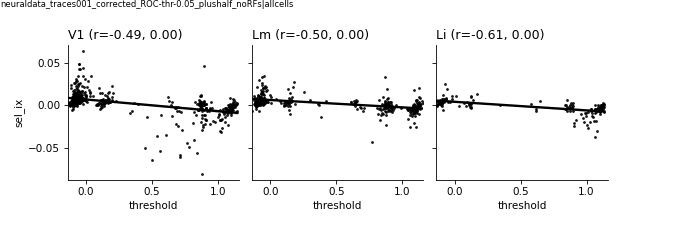

In [431]:
fg = sns.lmplot(col='visual_area', x='threshold', y='sel_ix', data=passdf, height=3,
           scatter_kws={'color':'k', 's': 3}, markers='o', line_kws={'color': 'k'},
          col_order=visual_areas)
fg.set_titles('')

for va, g in passdf.groupby(['visual_area']):
    xv = g['threshold'].values
    yv =  g['sel_ix'].values
    pears_r, pears_p = spstats.pearsonr(xv, yv)
    ai = visual_areas.index(va)
    fg.axes.flat[ai].set_title('%s (r=%.2f, %.2f)' % (va, pears_r, pears_p), loc='left')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

p3.label_figure(fg.fig, '%s|%s' % (data_id, selective_str))

# figname = 'lmplot_SELvTHR_%s-crit-%.2f__%s' % (selective_str, criterion, responsive_test)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)



<IPython.core.display.Javascript object>


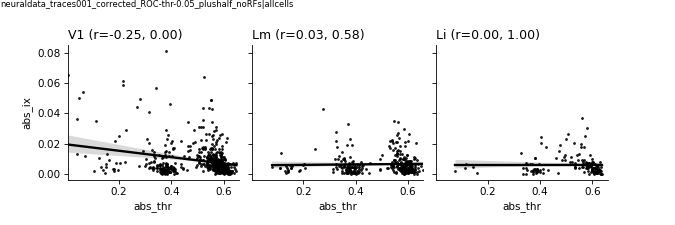

In [415]:
fg = sns.lmplot(col='visual_area', x='abs_thr', y='abs_ix', data=passdf, height=3,
          scatter_kws={'color':'k', 's': 3}, markers='o', line_kws={'color': 'k'},
          col_order=visual_areas)

fg.set_titles('')

for va, g in passdf.groupby(['visual_area']):
    xv = g['abs_thr'].values
    yv =  g['abs_ix'].values
    pears_r, pears_p = spstats.pearsonr(xv, yv)
    ai = visual_areas.index(va)
    fg.axes.flat[ai].set_title('%s (r=%.2f, %.2f)' % (va, pears_r, pears_p), loc='left')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

p3.label_figure(fg.fig, '%s|%s' % (data_id, selective_str))

# figname = 'lmplot_absSELvTHR_%s-crit-%.2f__%s' % (selective_str, criterion, responsive_test)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)


In [ ]:
glob.glob(os.path.join(traceid_dir, 'neurometric', 'aucs', '%s.pkl' % curr_results_id))

# test 1 cell/fov

## Load split trial input data

In [ ]:

dst_dir = os.path.join(traceid_dir, 'neurometric', 'aucs')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

    
sdf = SDF[dk].copy()


morph_lut, a_morphs, b_morphs = get_morph_levels()

ndf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
ndf = add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs)
    

curr_results_id = decode_analysis_id(visual_area=va, responsive_test=responsive_test,
                       response_type='dff', overlap_str='noRF', trial_epoch='plushalf')

print(curr_results_id)

traceid_dir = get_tracedir_from_datakey(dk)
dst_dir = os.path.join(traceid_dir, 'neurometric', 'aucs')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


decoding_outfile = os.path.join(traceid_dir, 'decoding', 'inputdata_%s.pkl' % curr_results_id)
assert os.path.exists(decoding_outfile),\
        "(%s, %s) No <%s> results: %s" % (dk, va, decode_prefix, results_id)

with open(decoding_outfile, 'rb') as f:
    indata = pkl.load(f, encoding='latin1')
trialdf = indata['input_trials']


In [359]:
rid = 217

auc_r = mean_auc[mean_auc['cell']==rid].copy().reset_index(drop=True)
auc_r['n_chooseB'] = auc_r['AUC']*auc_r['n_trials']


In [360]:
auc_r.dtypes

cell            int64
morphlevel      int64
size          float64
arousal        object
iteration       int64
AUC           float64
n_trials        int64
Eff             int64
n_chooseB     float64
dtype: object

            trial     response     baseline     size  morphlevel  morphstep  \
object                                                                        
A       666.90625  1177.519314  1053.120576  30.3125         0.0        4.0   
B       693.53125  1120.601193  1072.330808  30.3125       106.0        4.0   

        morph_ix  
object            
A            0.0  
B            1.0  
(45, 50) (5, 50) 45


<IPython.core.display.Javascript object>


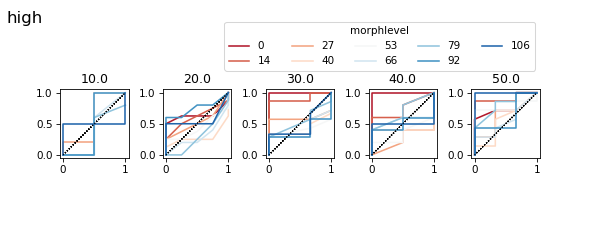

            trial     response    baseline     size  morphlevel  morphstep  \
object                                                                       
A       861.28125  1134.037619  1050.25437  30.3125         0.0        4.0   
B       863.18750  1096.068005  1062.43037  30.3125       106.0        4.0   

        morph_ix  
object            
A            0.0  
B            1.0  
(45, 50) (5, 50) 45


<IPython.core.display.Javascript object>


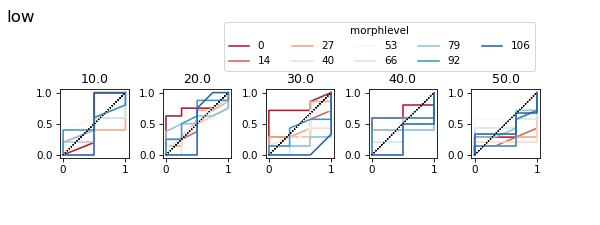

In [284]:
# a_cond='high'
# a_df = curr_trials[(curr_trials['iteration']==0) & (curr_trials.arousal==a_cond)].copy()

for a_cond, a_df in curr_trials[(curr_trials['iteration']==0)].groupby(['arousal']):
    curr_rdf = ndf[ndf['trial'].isin(a_df['trial'].values) & (ndf['cell']==rid)].copy()

    fig = plot_auc_for_cell(curr_rdf, param='morphlevel', class_a=0, class_b=106, cmap='RdBu')
    fig.text(0.01, 0.9, a_cond, fontsize=16)

In [364]:
auc_r

cell  morphlevel  size arousal  iteration       AUC  n_trials  Eff  \
0       217           0  10.0    high          0  0.000000         5    0   
1       217           0  10.0    high          1  0.500000         5    0   
2       217           0  10.0    high          2  0.450000         5    0   
3       217           0  10.0    high          3  0.550000         5    0   
4       217           0  10.0    high          4  1.000000         5    0   
...     ...         ...   ...     ...        ...       ...       ...  ...   
18355   217         106  50.0     low        199  0.444444         7    0   
18356   217         106  50.0     low        200  0.833333         7    0   
18357   217         106  50.0     low        201  0.444444         7    0   
18358   217         106  50.0     low        202  0.444444         7    0   
18359   217         106  50.0     low        203  0.888889         7    0   

       n_chooseB  
0       0.000000  
1       2.500000  
2       2.250000  
3       2.750000  
4       5.000000  
...          ...  
18355   3.111111  
18356   5.833333  
18357   3.111111  
18358   3.111111  
18359   6.222222  

[18360 rows x 9 columns]

<IPython.core.display.Javascript object>


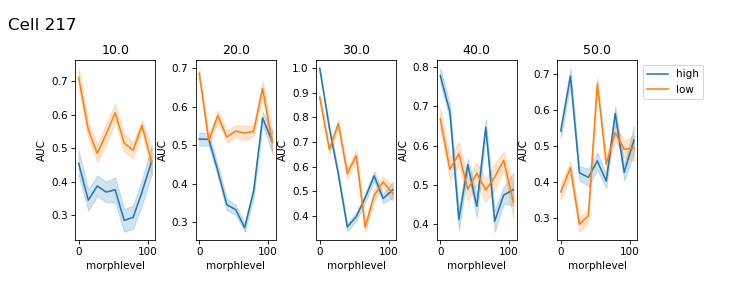

In [366]:
fig, axn = pl.subplots(1,len(sizes), figsize=(10,4))
for ax, (sz, sg) in zip(axn.flat, auc_r.groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax)
    ax.legend_.remove()
    ax.set_title(sz)
    
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.9, 'Cell %i' % rid, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [335]:
ts = curr_trials[(curr_trials['iteration']==0) & (curr_trials['arousal']=='high')]['trial'].values

ndf[(ndf['trial'].isin(ts)) & (ndf['cell']==rid)].sort_values(by='config').groupby(['config']).count()

datakey  trial  visual_area  cell  response  baseline  size  \
config                                                                   
config006        5      5            5     5         5         5     5   
config007        8      8            8     8         8         8     8   
config008        7      7            7     7         7         7     7   
config009        5      5            5     5         5         5     5   
config010        7      7            7     7         7         7     7   
config011        5      5            5     5         5         5     5   
config012        8      8            8     8         8         8     8   
config013        7      7            7     7         7         7     7   
config014        5      5            5     5         5         5     5   
config015        7      7            7     7         7         7     7   
config016        5      5            5     5         5         5     5   
config017        8      8            8     8         8         8     8   
config018        7      7            7     7         7         7     7   
config019        5      5            5     5         5         5     5   
config020        7      7            7     7         7         7     7   
config021        5      5            5     5         5         5     5   
config022        8      8            8     8         8         8     8   
config023        6      6            6     6         6         6     6   
config024        5      5            5     5         5         5     5   
config025        7      7            7     7         7         7     7   
config026        5      5            5     5         5         5     5   
config027        8      8            8     8         8         8     8   
config028        7      7            7     7         7         7     7   
config029        5      5            5     5         5         5     5   
config030        7      7            7     7         7         7     7   
config031        5      5            5     5         5         5     5   
config032        5      5            5     5         5         5     5   
config033        7      7            7     7         7         7     7   
config034        5      5            5     5         5         5     5   
config035        7      7            7     7         7         7     7   
config036        5      5            5     5         5         5     5   
config037        8      8            8     8         8         8     8   
config038        7      7            7     7         7         7     7   
config039        5      5            5     5         5         5     5   
config040        7      7            7     7         7         7     7   
config041        5      5            5     5         5         5     5   
config042        5      5            5     5         5         5     5   
config043        7      7            7     7         7         7     7   
config044        5      5            5     5         5         5     5   
config045        7      7            7     7         7         7     7   
config046        5      5            5     5         5         5     5   
config047        8      8            8     8         8         8     8   
config048        7      7            7     7         7         7     7   
config049        5      5            5     5         5         5     5   
config050        7      7            7     7         7         7     7   

           morphlevel  morphstep  morph_ix  object  
config                                              
config006           5          5         5       5  
config007           8          8         8       8  
config008           7          7         7       7  
config009           5          5         5       5  
config010           7          7         7       7  
config011           5          5         5       5  
config012           8          8         8       8  
config013           7          7         7       7  
co

In [362]:
auc_r.head()

cell  morphlevel  size arousal  iteration   AUC  n_trials  Eff  n_chooseB
0   217           0  10.0    high          0  0.00         5    0       0.00
1   217           0  10.0    high          1  0.50         5    0       2.50
2   217           0  10.0    high          2  0.45         5    0       2.25
3   217           0  10.0    high          3  0.55         5    0       2.75
4   217           0  10.0    high          4  1.00         5    0       5.00

# Calculate AUC as performance

In [92]:
AUC = aggregate_AUC(DATA, SDF, param='morphlevel', midp=53, reverse_eff=False,
                  selective_only=False, selective_df=None, create_new=False)

... creating new AUC dfs


In [173]:
mAUC

cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0        113        0      0  0.590000           0  10.0    0        30   
1        113        1      1  0.543333          14  10.0    0        30   
2        113        2      2  0.596667          27  10.0    0        30   
3        113        3      3  0.523333          40  10.0    0        30   
4        113        4      4  0.644444          53  10.0    0        30   
...      ...      ...    ...       ...         ...   ...  ...       ...   
134175   390       40     35  0.666090          53  50.0  106        34   
134176   390       41     36  0.524955          66  50.0  106        33   
134177   390       42     37  0.672014          79  50.0  106        33   
134178   390       43     38  0.628342          92  50.0  106        33   
134179   390       44     39  0.683601         106  50.0  106        33   

       visual_area              datakey  
0               Li  20190315_JC070_fov1  
1               Li  20190315_JC070_fov1  
2               Li  20190315_JC070_fov1  
3               Li  20190315_JC070_fov1  
4               Li  20190315_JC070_fov1  
...            ...                  ...  
134175          V1  20191006_JC110_fov1  
134176          V1  20191006_JC110_fov1  
134177          V1  20191006_JC110_fov1  
134178          V1  20191006_JC110_fov1  
134179          V1  20191006_JC110_fov1  

[134180 rows x 10 columns]

In [25]:
importlib.reload(p3)

<module 'functools3' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/functools3.py'>

In [55]:
va='V1'
dk = '20190507_JC083_fov1'
midp=53
ndf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
sdf = SDF[dk]

In [57]:
morphlevels = sdf['morphlevel'].unique()
max_morph = max(morphlevels)

assert midp in  morphlevels, "... Unknown midpoint in morphs: %s" % str(morphlevels)

morph_lut, a_morphs, b_morphs = p3.get_morph_levels(levels=morphlevels, midp=midp)
ndf = p3.add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs, midp=53)
    
# ndf['size'] = [sdf['size'][c] for c in ndf['config']]
# ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
# ndf = ndf[(ndf['morphlevel']!=-1)].copy()

# morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
# # update neuraldata
# ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
# ndf['morph_ix'] = [m/float(max_morph) for m in ndf['morphlevel']]

# ndf['object'] = None
# ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
# ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
# ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'


In [58]:

# # get selective cells
# seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
# sel_cells = seldf['cell'].unique().astype(int)


In [59]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse'

In [60]:
rid = 8
rdf = ndf[ndf['cell']==rid].copy()


[0, 1, 2, 3, 4]


<IPython.core.display.Javascript object>


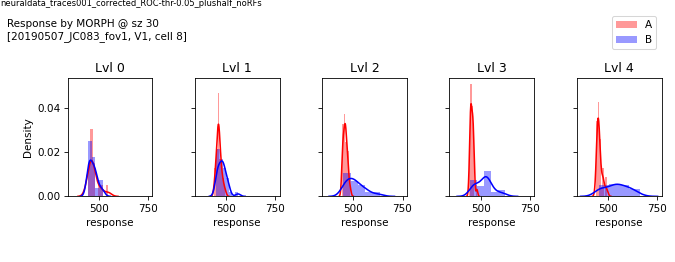

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

V1_20190507_JC083_fov1_rid008_sz30_PSTH_morphstep


In [80]:
plotparam = 'morphstep'
morph_levels=sorted(rdf[plotparam].unique())
print(morph_levels)
fig, axn = pl.subplots(1, len(morph_levels), sharex=True, sharey=True, figsize=(9,3.5))

curr_sz=30
for si, (sz, g) in enumerate(rdf[(rdf['size']==curr_sz) 
                                 & (rdf['morphlevel']!=-1)].groupby([plotparam])):
    ax=axn[si]
    if sz==0:
        if plotparam=='morphlevel':
            sns.distplot(g[g['object']=='A']['response'][0::2], ax=ax, color='r', label='A')
            sns.distplot(g[g['object']=='A']['response'][1::2], ax=ax, color='b', label='B')
        else:
            sns.distplot(g[g['object']=='M']['response'][0::2], ax=ax, color='r', label='A')
            sns.distplot(g[g['object']=='M']['response'][1::2], ax=ax, color='b', label='B')
    else:
        if plotparam=='morphlevel':
            sns.distplot(rdf[(rdf['size']==curr_sz) & (rdf[plotparam]==0)]['response'], ax=ax, color='r', label='A')
            sns.distplot(g['response'], ax=ax, color='b',label='B')
        else:
            sns.distplot(g[g['object']=='A']['response'], ax=ax, color='r',label='A')
            sns.distplot(g[g['object']=='B']['response'], ax=ax, color='b',label='B')

    ax.set_title('Lvl %i' % sz)
    
pl.subplots_adjust(left=0.1, right=0.98, bottom=0.25, top=0.7, wspace=0.5)
ax.legend(bbox_to_anchor=(1., 1.2), loc='lower right')
fig.text(0.01, 0.85, 'Response by MORPH @ sz %i\n[%s, %s, cell %i]' \
            % (curr_sz, dk, va, rid))

p3.label_figure(fig, data_id)
figname = '%s_%s_rid%03d_sz%i_PSTH_%s' % (va, dk, rid, curr_sz, plotparam)
pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))
print(figname)

In [73]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse'

In [92]:
sig='gauss'

class_a=0
class_b=106
include_ref=True
n_crit=20

rid = 8 #65 #217 #90 #217
assert rid in ndf['cell'].unique()
rdf = ndf[ndf['cell']==rid].copy()

means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
Eff = class_a if means['response']['A'] > means['response']['B'] else class_b


param = 'morphlevel'
# reverse_eff = param!='morphstep'
aucs, p_hits, p_fas, resp_cfgs1 = p3.get_auc_AB(rdf, param=param, n_crit=50, allow_negative=allow_negative,
                  class_a=0, class_b=106, return_probs=True)

sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
print(sigmoid_)

gauss


In [91]:
importlib.reload(p3)

<module 'functools3' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/functools3.py'>

In [84]:
# aucs = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=False)


In [85]:
# p_fas[sizes.index(sz), :].shape

NameError: name 'p_fas' is not defined

<IPython.core.display.Javascript object>


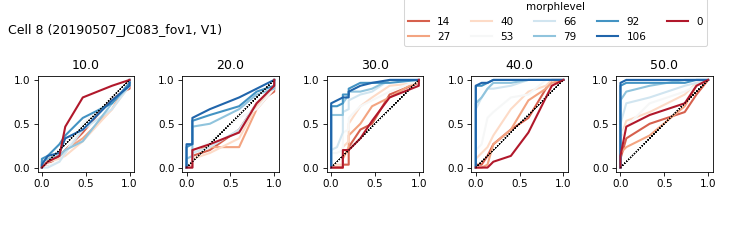

Text(0.01, 0.85, 'Cell 8 (20190507_JC083_fov1, V1)')

In [94]:
sizes = sorted(aucs['size'].unique())
cmap='plasma' if param=='morphstep' else 'RdBu'
lw=2
# Plot----
mdiffs = sorted(aucs[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(10,3))    
for mi, (sz, mp) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.25), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
fig.text(0.01, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)


In [29]:
importlib.reload(ps.psigniplot)

<module 'psignifit.psigniplot' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [79]:
# aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=True)

curr_sz=30
auc_ = aucs[aucs['size']==curr_sz].copy()
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
data_ = data_matrix_from_auc(auc_, param=param,normalize=True)
data_

array([[ 0.        , 28.        , 30.        ],
       [ 0.13207547, 24.        , 30.        ],
       [ 0.25471698, 23.        , 30.        ],
       [ 0.37735849, 20.        , 30.        ],
       [ 0.5       , 22.        , 30.        ],
       [ 0.62264151, 19.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 20.        , 30.        ],
       [ 1.        , 21.        , 30.        ]])

<IPython.core.display.Javascript object>


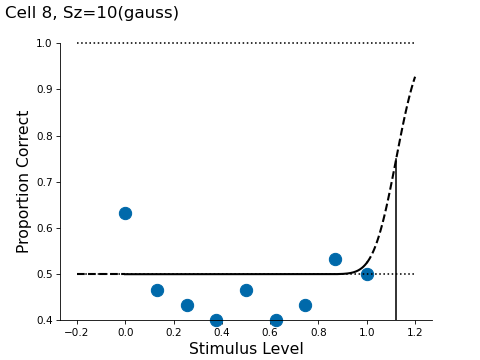

[1.12 0.24 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


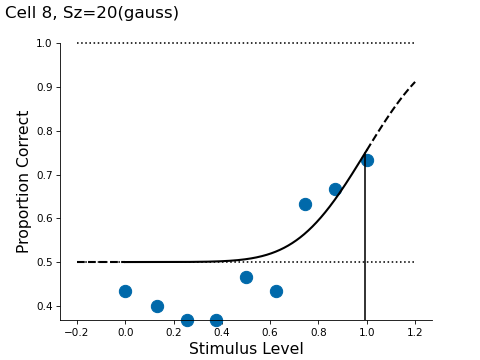

[0.99 0.73 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


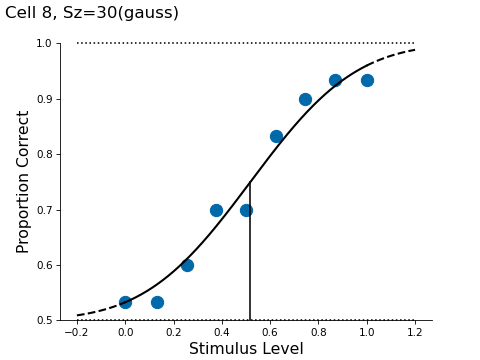

[0.52 1.13 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


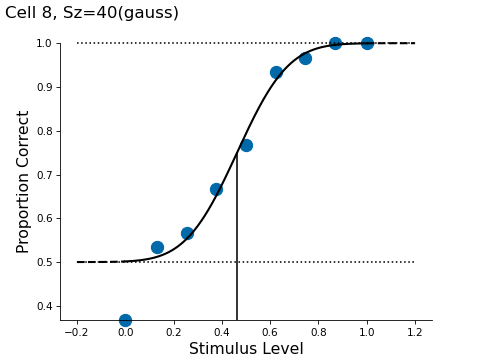

[0.46 0.55 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


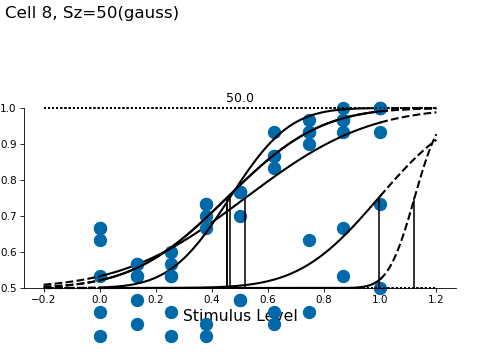

[0.45 0.86 0.   0.5  0.  ]


In [97]:

results={}
for curr_sz, auc_ in aucs.groupby(['size']):
    auc_ = aucs[aucs['size']==curr_sz].copy()
    auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
    data_ = p3.data_matrix_from_auc(auc_, param=param,normalize=True)


    ni = 0
    opts = dict()
    opts['sigmoidName'] = sigmoid_

    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)
    print(res_['Fit'].round(2))
    # norm: [0.74 1.27 0.   0.5  0.  ]
    # gumbel: [0.76 1.18 0.   0.5  0.  ]
    # neg_gumbel: [0.16 0.69 0.   0.5  0.  ]

    # Weibull: [0.88 0.5  0.   0.5  0.  ]
    # [0.78 0.91 0.   0.5  0.  ]
    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level

    info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
                                 lineColor='k', label=info_str)
    fig.text(0.01, 0.95, 'Cell %i, Sz=%i(%s)' % (rid, curr_sz, sigmoid_), fontsize=16)

    results[curr_sz] = res_

<IPython.core.display.Javascript object>


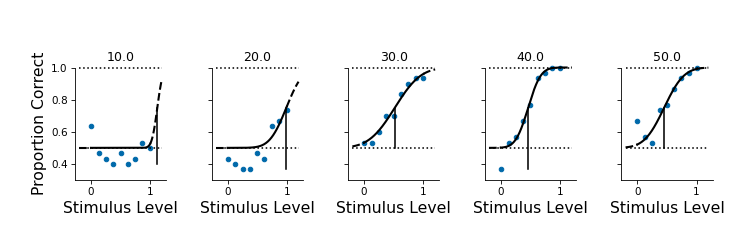

In [104]:
fig, axn = pl.subplots(1, len(sizes), figsize=(10,3), sharex=True, sharey=True)    

results[curr_sz] = res_
for curr_sz, res_ in results.items():
    ai = sizes.index(curr_sz)
    ax=axn[ai]
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
                                 lineColor='k', label=info_str, dataSize=5)
    ax.set_title(curr_sz)
    if ai>0:
        ax.set_ylabel('')
    ax.set_ylim([0.3, 1])
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)


In [442]:
curr_fdir = os.path.join(curr_dst_dir, 'middle_thr')
if not os.path.exists(curr_fdir):
    os.makedirs(curr_fdir)
print(curr_fdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples/middle_thr


In [435]:
B = onefit[(onefit['threshold']<=0.7) & (onefit['threshold']>=0.3)]
B

threshold     width        lambda  gamma           eta     slope  \
335    0.686359  1.794741  1.482067e-09    0.5  2.665707e-08  0.365625   
791    0.654198  1.900265  1.016213e-01    0.5  3.197070e-08 -0.260953   
1567   0.554792  1.188344  2.900773e-07    0.5  6.932014e-07  0.552198   
1568   0.561396  0.718166  4.549778e-02    0.5  4.901443e-10  0.824028   
1569   0.561142  0.465011  1.013230e-01    0.5  1.607858e-08  1.067613   
2074   0.676355  2.103228  1.912975e-07    0.5  3.333462e-06  0.311997   
2758   0.421500  1.969336  5.462827e-07    0.5  2.626881e-07 -0.333209   
2774   0.370833  1.773618  4.934650e-10    0.5  1.645039e-05 -0.369979   
3484   0.337220  1.464177  4.586619e-08    0.5  6.627823e-07 -0.448171   
3681   0.699913  2.099876  4.090629e-08    0.5  9.230547e-08  0.312495   
3687   0.556401  0.848384  2.442102e-02    0.5  2.227349e-09  0.734171   
3688   0.382836  0.674393  5.078619e-09    0.5  4.470198e-08  0.973025   
3689   0.498510  0.761894  1.654202e-06    0.5  6.696080e-10  0.861274   
3702   0.587796  0.361930  1.256958e-01    0.5  3.238132e-08  1.235207   
3703   0.661175  1.525423  8.372505e-09    0.5  5.151258e-10  0.430177   
3809   0.511059  1.978894  4.332252e-05    0.5  1.765681e-08  0.331571   
3853   0.434538  1.972895  4.238995e-07    0.5  4.535809e-10  0.332608   
3858   0.592316  1.757203  2.049216e-04    0.5  3.311967e-09  0.373282   
3989   0.330680  1.931851  3.740848e-05    0.5  1.062832e-09 -0.339650   
4013   0.579004  0.668581  4.801179e-02    0.5  2.511621e-09  0.879364   
4023   0.654253  1.105225  1.293824e-06    0.5  4.664777e-08  0.593725   
4024   0.528603  1.331363  3.671811e-08    0.5  2.495719e-07  0.492879   
4032   0.686355  1.528268  1.130286e-04    0.5  9.630824e-11  0.429279   
4207   0.344932  0.662654  1.577165e-01    0.5  2.323121e-09  0.561443   
4208   0.455906  0.243807  1.453686e-01    0.5  2.092368e-07  1.651123   
4326   0.665594  0.432380  1.599262e-01    0.5  2.928451e-07 -0.847270   
4354   0.340752  1.230491  9.837463e-09    0.5  7.699369e-10 -0.533284   
5019   0.321684  1.967102  0.000000e+00    0.5  0.000000e+00 -0.333588   
5317   0.694207  2.076621  3.469461e-09    0.5  9.098479e-08  0.315995   
6057   0.302880  1.259792  4.205647e-08    0.5  5.342828e-08 -0.520881   
6153   0.339918  2.235299  1.921864e-08    0.5  1.615589e-08 -0.293563   
6659   0.327636  2.002456  2.060662e-08    0.5  1.009655e-08 -0.327698   

           thr visual_area              datakey  cell  size  Eff  
335   0.686359          Li  20190602_JC091_fov1    89  10.0  106  
791   0.466260          Li  20190612_JC099_fov1   123  20.0    0  
1567  0.554792          Lm  20190504_JC078_fov1   194  30.0  106  
1568  0.588858          Lm  20190504_JC078_fov1   194  40.0  106  
1569  0.606956          Lm  20190504_JC078_fov1   194  50.0  106  
2074  0.676356          Lm  20190508_JC083_fov1   105  50.0  106  
2758  0.421499          Lm  20190517_JC083_fov1   117  40.0    0  
2774  0.370833          Lm  20190517_JC083_fov1   124  50.0    0  
3484  0.337220          Lm  20190627_JC091_fov1   163  50.0    0  
3681  0.699913          V1  20190507_JC083_fov1     5  20.0  106  
3687  0.573009          V1  20190507_JC083_fov1     8  30.0  106  
3688  0.382836          V1  20190507_JC083_fov1     8  40.0  106  
3689  0.498511          V1  20190507_JC083_fov1     8  50.0  106  
3702  0.635559          V1  20190507_JC083_fov1    14  30.0  106  
3703  0.661175          V1  20190507_JC083_fov1    14  40.0  106  
3809  0.511125          V1  20190507_JC083_fov1    85  50.0  106  
3853  0.434539          V1  20190507_JC083_fov1   126  40.0  106  
3858  0.592590          V1  20190507_JC083_fov1   128  40.0  106  
3989  0.330625          V1  20190509_JC078_fov1    83  50.0    0  
4013  0.606141          V1  20190510_JC083_fov1     9  40.0  106  
4023  0.654254          V1  20190510_JC083_fov1    20  40.0  106  
4024  0.528603          V1  20190510_JC083_fov1    20  50.0  106  
4032  0.686486        

Li 20190602_JC091_fov1 89 10.0 0.8345238095238096
240


<IPython.core.display.Javascript object>


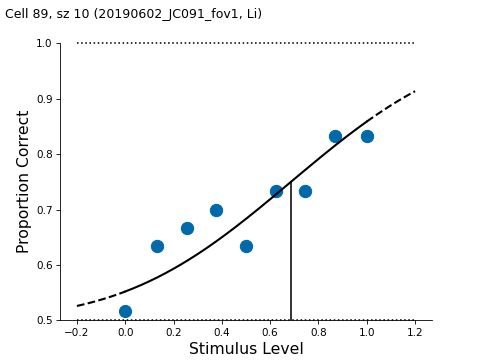

Li 20190612_JC099_fov1 123 20.0 0.8755555555555556
240


<IPython.core.display.Javascript object>


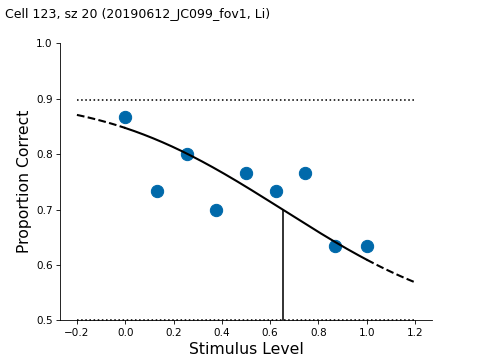

Lm 20190504_JC078_fov1 194 30.0 0.9366666666666666
240


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


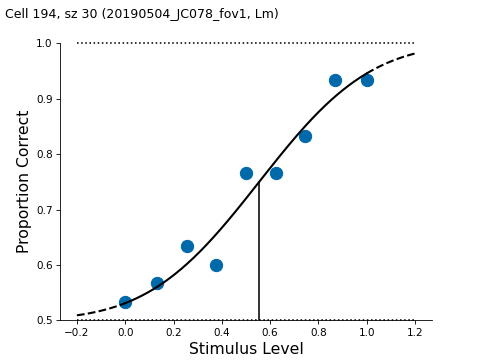

Lm 20190504_JC078_fov1 194 40.0 0.9311111111111111
240


<IPython.core.display.Javascript object>


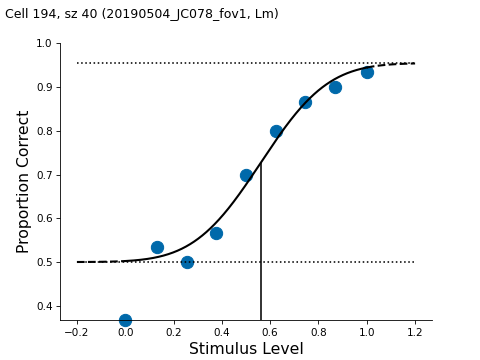

Lm 20190504_JC078_fov1 194 50.0 0.9133333333333333
240


<IPython.core.display.Javascript object>


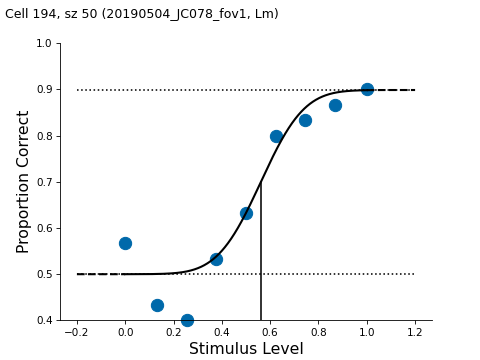

Lm 20190508_JC083_fov1 105 50.0 0.7857142857142857
240


<IPython.core.display.Javascript object>


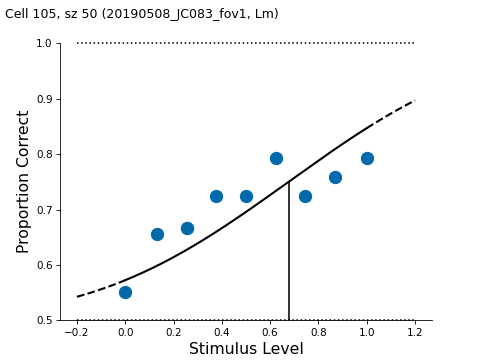

Lm 20190517_JC083_fov1 117 40.0 0.8666666666666667
240


<IPython.core.display.Javascript object>


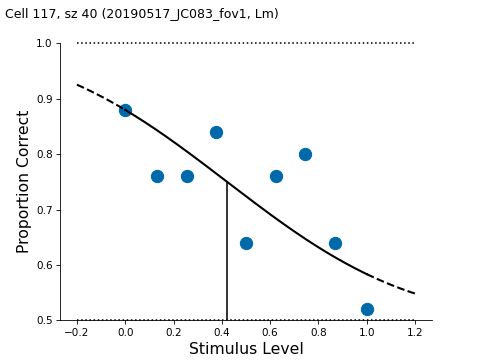

Lm 20190517_JC083_fov1 124 50.0 0.885
240


<IPython.core.display.Javascript object>


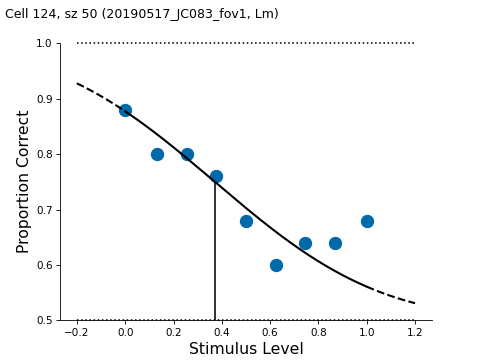

Lm 20190627_JC091_fov1 163 50.0 0.8433333333333334
240


<IPython.core.display.Javascript object>


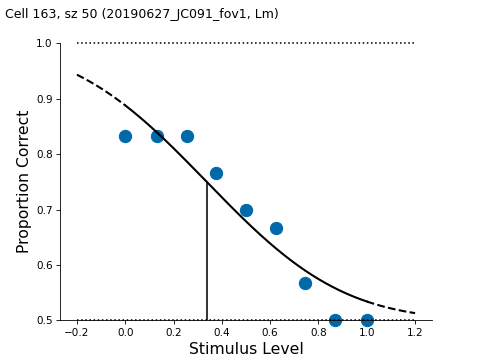

V1 20190507_JC083_fov1 5 20.0 0.7933333333333332
240


<IPython.core.display.Javascript object>


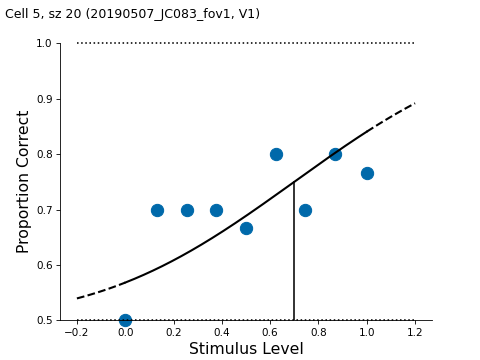

V1 20190507_JC083_fov1 8 30.0 0.9222222222222223
240


<IPython.core.display.Javascript object>


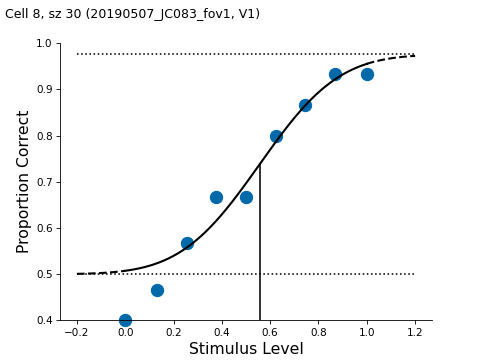

V1 20190507_JC083_fov1 8 40.0 0.9966666666666667
240


<IPython.core.display.Javascript object>


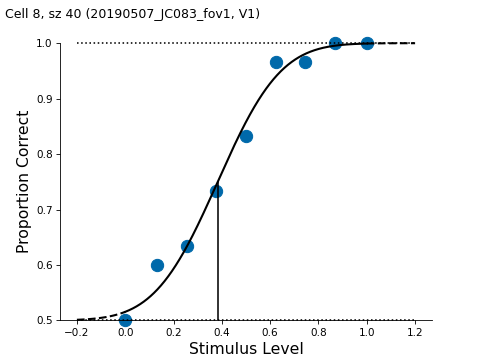

V1 20190507_JC083_fov1 8 50.0 0.9922222222222223
240


<IPython.core.display.Javascript object>


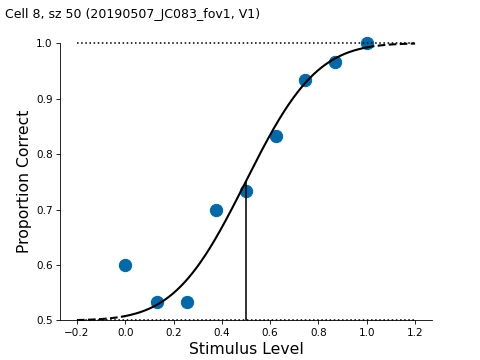

V1 20190507_JC083_fov1 14 30.0 0.8544444444444445
240


<IPython.core.display.Javascript object>


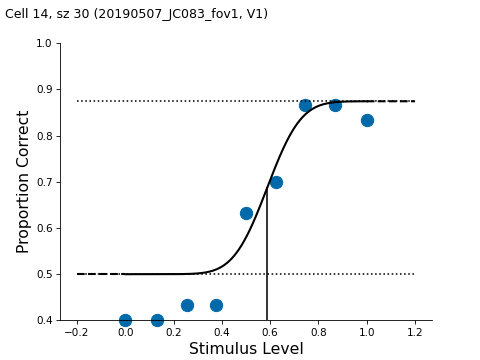

V1 20190507_JC083_fov1 14 40.0 0.8577777777777779
240


<IPython.core.display.Javascript object>


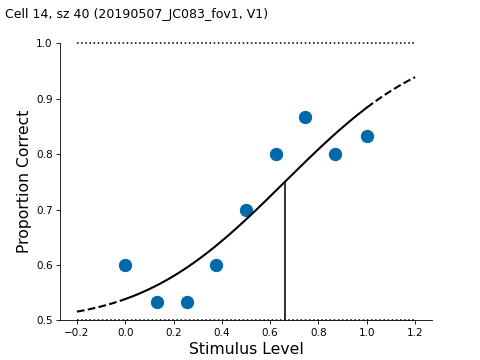

V1 20190507_JC083_fov1 85 50.0 0.8833333333333333
240


<IPython.core.display.Javascript object>


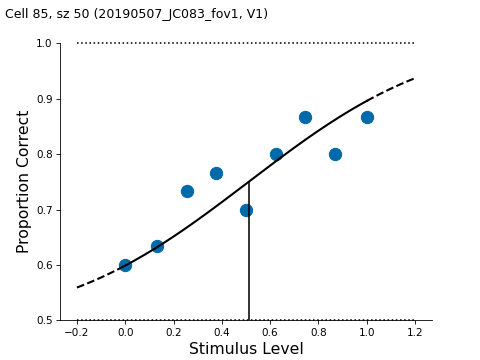

V1 20190507_JC083_fov1 126 40.0 0.8977777777777778
240


<IPython.core.display.Javascript object>


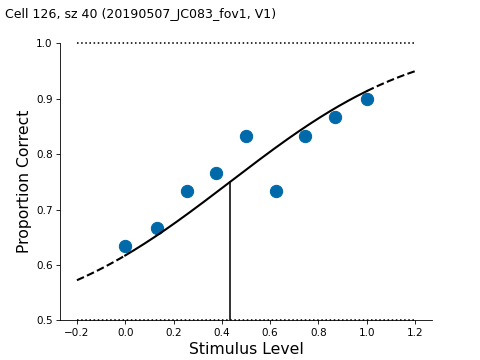

V1 20190507_JC083_fov1 128 40.0 0.8555555555555555
240


<IPython.core.display.Javascript object>


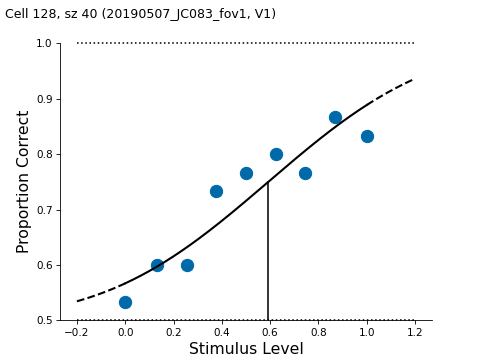

V1 20190509_JC078_fov1 83 50.0 0.82
240


<IPython.core.display.Javascript object>


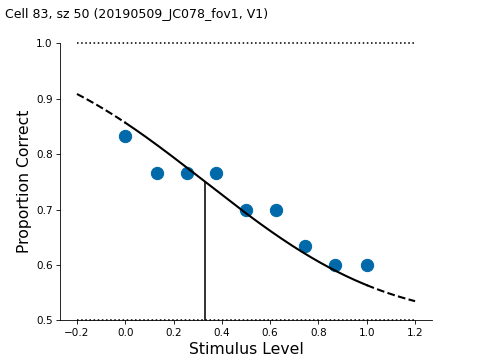

V1 20190510_JC083_fov1 9 40.0 0.9453781512605042
240


<IPython.core.display.Javascript object>


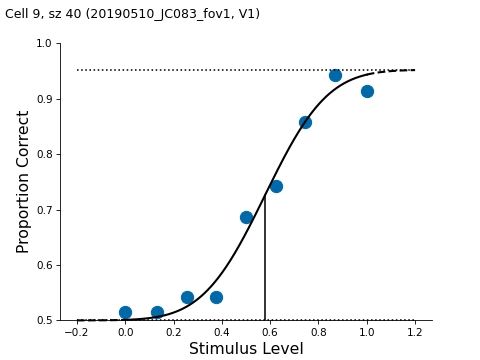

V1 20190510_JC083_fov1 20 40.0 0.8949579831932774
240


<IPython.core.display.Javascript object>


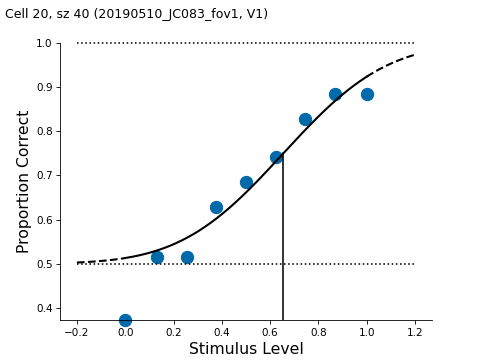

V1 20190510_JC083_fov1 20 50.0 0.9193277310924369
240


<IPython.core.display.Javascript object>


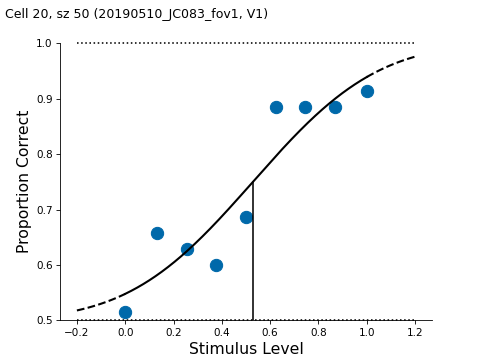

V1 20190510_JC083_fov1 23 30.0 0.8563025210084034
240


<IPython.core.display.Javascript object>


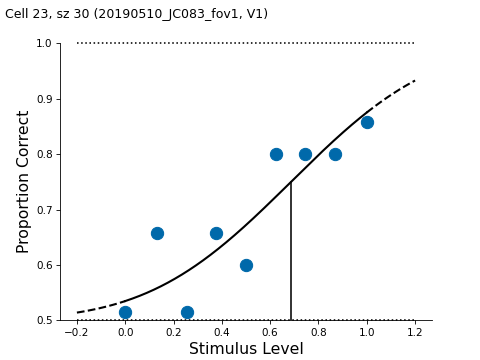

V1 20190511_JC083_fov1 32 30.0 0.8944444444444444
240


<IPython.core.display.Javascript object>


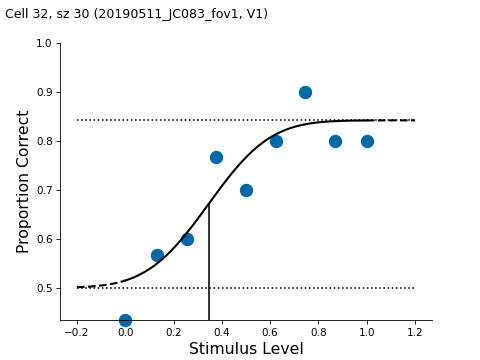

V1 20190511_JC083_fov1 32 40.0 0.9033333333333333
240


<IPython.core.display.Javascript object>


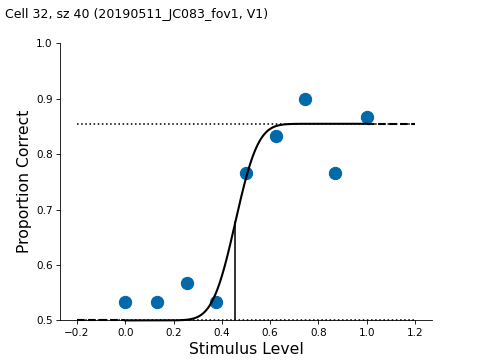

V1 20190511_JC083_fov1 119 20.0 0.8944444444444444
240


<IPython.core.display.Javascript object>


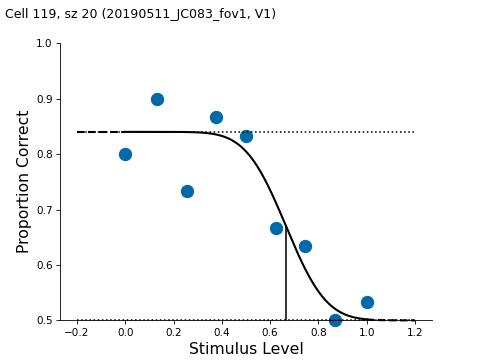

V1 20190511_JC083_fov1 143 50.0 0.9177777777777778
240


<IPython.core.display.Javascript object>


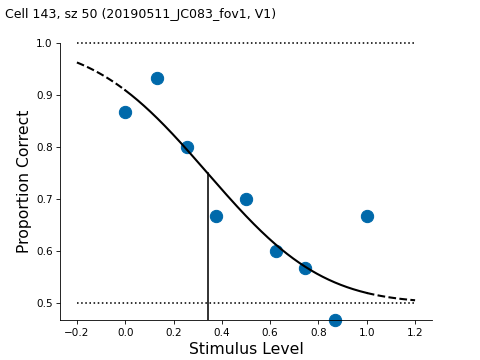

V1 20190613_JC097_fov1 125 50.0 0.8933333333333333
240


<IPython.core.display.Javascript object>


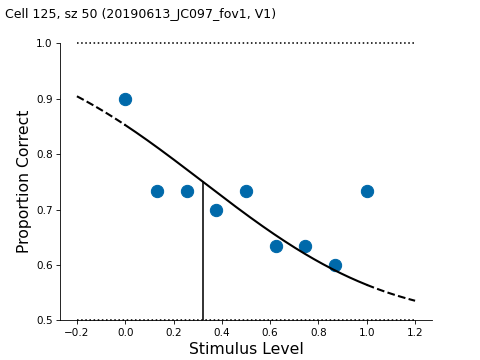

V1 20190616_JC097_fov1 147 30.0 0.81
240


<IPython.core.display.Javascript object>


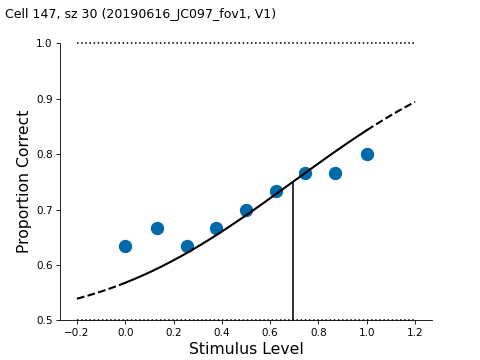

V1 20190617_JC097_fov1 254 30.0 0.95
240


<IPython.core.display.Javascript object>


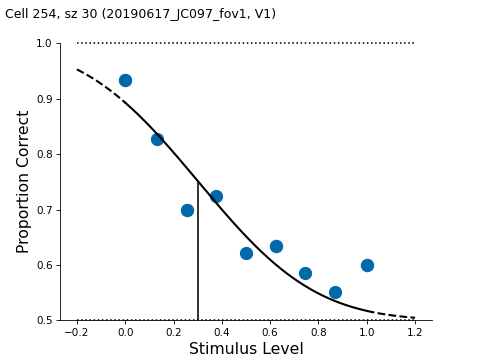

V1 20190617_JC097_fov1 414 40.0 0.8423645320197044
240


<IPython.core.display.Javascript object>


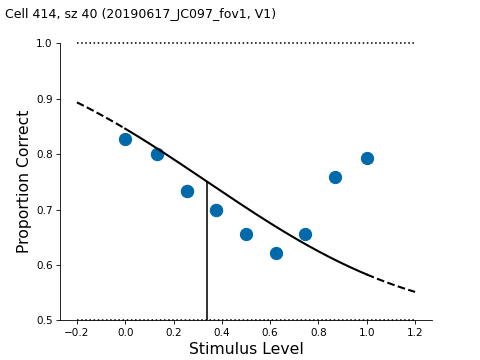

V1 20190622_JC085_fov1 335 50.0 0.8511111111111112
240


<IPython.core.display.Javascript object>


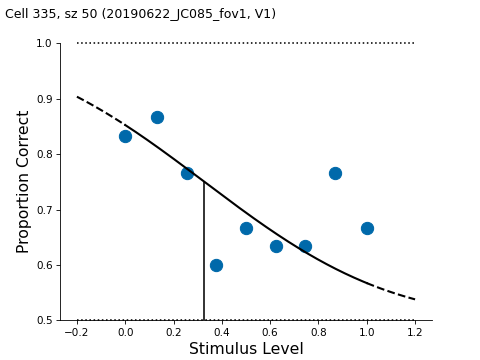

In [443]:
results={}
for (va,dk, ri, sz), g in B.groupby(['visual_area', 'datakey', 'cell', 'size']):
    
    mx = pAUC[(pAUC.visual_area==va) & (pAUC.datakey==dk) 
              & (pAUC['cell']==ri) & (pAUC['size']==sz)]['AUC'].max()
    print(va, dk, ri, sz, mx)

    traceid_dir = p3.get_tracedir_from_datakey(dk)
    sigmoid_dir='gauss'

    rfn = glob.glob(os.path.join(traceid_dir, 'neurometric', 'fits', 
                                         sigmoid_dir, 'rid%03d.pkl' % ri))[0]
    print(ri)
    with open(rfn, 'rb') as f:
        rd = pkl.load(f)
    k = '%s_%s_rid%03d_sz%i' % (va, dk, ri, sz)
    res = rd['results'][sz]
    results[k] = res

    fig, ax = pl.subplots()
    #res = results[rid][sz]
    # info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
    ax = ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=True, 
                                 lineColor='k', label=rid)

    fig.text(0.01, 0.95, 'Cell %i, sz %i (%s, %s)' % (ri, sz, dk, va), fontsize=12)

    figname = 'fit_%s_%s_rid%03d_sz%i' % (va, dk, ri, sz)
    pl.savefig(os.path.join(curr_fdir, '%s.svg' % figname))

In [579]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples'

## Test loading

In [127]:
# Cells that pass performance criterion
pass_cells = currAUC[currAUC['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(currAUC['cell'].unique()), max_auc))
pass_auc = currAUC[currAUC['cell'].isin(pass_cells)].copy()
if len(pass_cells)==0:
    print("****[%s, %s] no cells." % (va, dk))


# Best config (size) for each cell
max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
assert len(pass_cells)==len(best_sz_per_cell)
if len(best_sz_per_cell)==0:
    print("****[%s, %s] no cells." % (va, dk))

best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])


104 of 184 cells pass crit (0.70)


In [ ]:
    # Cells that pass performance criterion
    pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
    print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
    pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()
    if len(pass_cells)==0:
        print("****[%s, %s] no cells." % (va, dk))
        continue

    # Best config (size) for each cell
#     max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
#     ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
#     best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
#     assert len(pass_cells)==len(best_sz_per_cell)
#     if len(best_sz_per_cell)==0:
#         print("****[%s, %s] no cells." % (va, dk))
#         continue
#     best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])


<IPython.core.display.Javascript object>


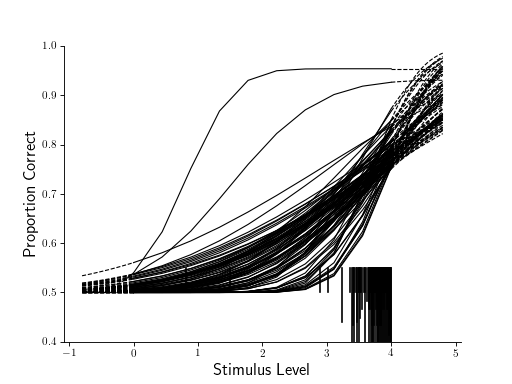

In [717]:
va='Lm'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=10)

<IPython.core.display.Javascript object>


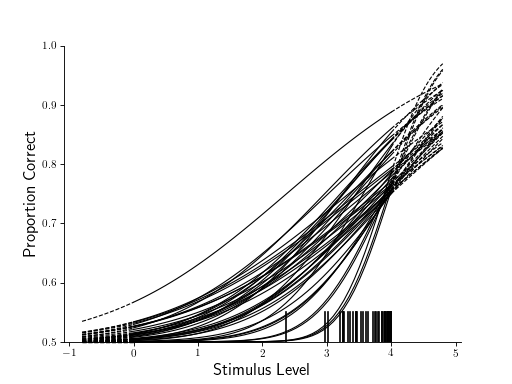

In [712]:
va='Li'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=50)

In [718]:
pass_estimates.head()

threshold     width        lambda  gamma           eta     slope  \
1    3.892998  1.914792  1.401999e-08    0.5  1.602869e-07  0.342701   
10   3.908429  3.619414  5.050646e-11    0.5  9.843335e-10  0.181301   
11   3.473057  7.589552  4.058454e-09    0.5  6.106602e-09  0.086461   
12   3.524935  7.561378  1.453119e-08    0.5  3.145398e-10  0.086783   
13   3.904229  5.447926  6.400028e-08    0.5  2.762301e-11  0.120450   

         thr  cell visual_area              datakey  
1   3.892998   261          Li  20190422_JC076_fov1  
10  3.908429    37          Li  20190602_JC091_fov1  
11  3.473057    38          Li  20190602_JC091_fov1  
12  3.524935    39          Li  20190602_JC091_fov1  
13  3.904230    40          Li  20190602_JC091_fov1

In [10]:
mean_est = pass_estimates.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


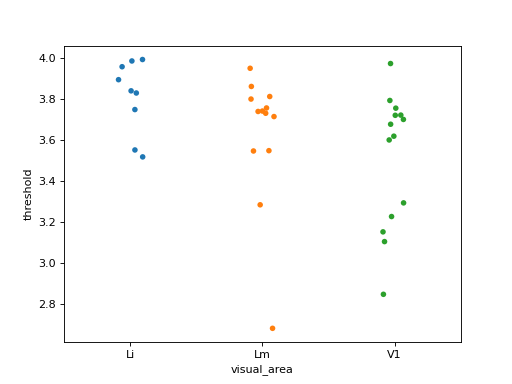

<AxesSubplot:xlabel='visual_area', ylabel='threshold'>

In [11]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='threshold', data=mean_est, ax=ax)

<IPython.core.display.Javascript object>


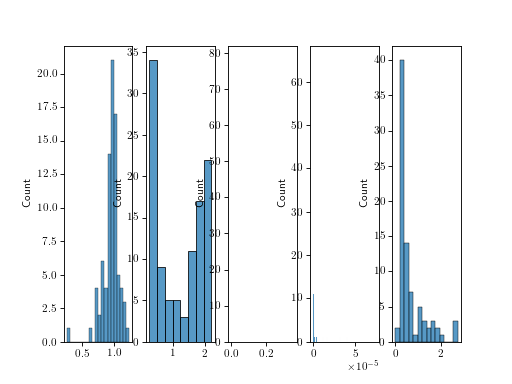

In [371]:
fig, axn = pl.subplots(1, n_params)
for ax, p in zip(axn.flat, ['threshold', 'width', 'lambda', 'eta', 'slope']):
    sns.histplot(data=estimates[p].values, ax=ax)



# Stimuli

In [40]:
morphlevels = SDF['20190616_JC097_fov1']['morphlevel'].unique()
stimdir = '/n/coxfs01/behavior-data/stimuli/D1D2M105_yrot_fine_steps/final'
curr_morphs = [m for m in sorted(morphlevels) if m!=-1]

image_fns = [os.path.join(stimdir, 'morph%i_y0.png' % m) for m in curr_morphs]
images={}
for m, fn in zip(curr_morphs, image_fns):
    images[m] = pl.imread(fn)

In [45]:
morph_lut, a_morphs, b_morphs = get_morph_levels()


In [46]:
morph_steps={}
for k, v in morph_lut.items():
    if v not in morph_steps.keys():
        morph_steps[v] =[]
    morph_steps[v].append(k)
morph_steps

{1: [40, 66], 2: [27, 79], 3: [14, 92], 4: [0, 106], 0: [53], -1: [-1]}

In [47]:
morphsteps = sorted([k for k, v in morph_steps.items() if k>=0])
morphsteps

[0, 1, 2, 3, 4]

<IPython.core.display.Javascript object>


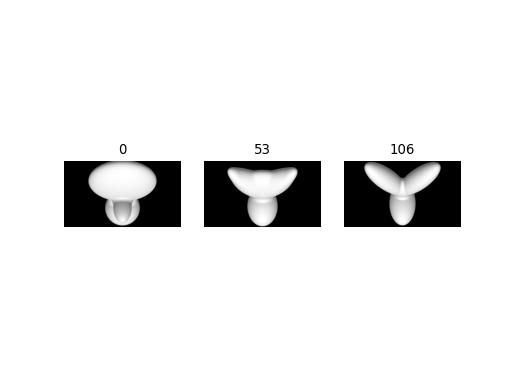

In [48]:
fig, axn = pl.subplots(1,3)
for ax, m in zip(axn.flat, [0, 53, 106]):
    ax.imshow(images[m], cmap='gray')
    ax.set_title(m)
    ax.axis('off')

<IPython.core.display.Javascript object>


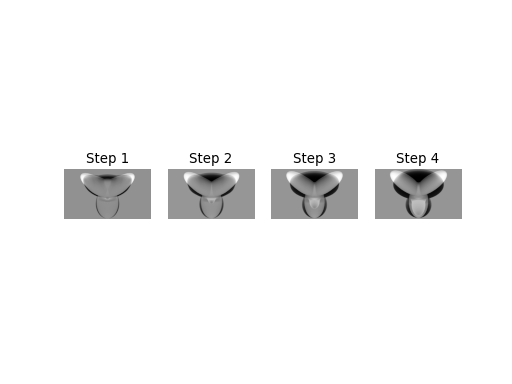

In [51]:
fig, axn = pl.subplots(1, len(morphsteps)-1)
diffs = {}
d=[]
for mstep, mims in morph_steps.items():
    if mstep <=0:
        continue
    ai = mstep-1
    ax = axn[ai]
    im1 = images[mims[0]]
    im2 = images[mims[1]] 
    diff_im = im1 - im2
    ax.imshow(diff_im, cmap='Greys')
    ax.axis('off')
    d.append(np.sum(diff_im))
    
    ediff = sp.spatial.distance.euclidean(im1.ravel(), im2.ravel())
    
    diffs[mstep] = ediff
    ax.set_title("Step %i" % mstep)
diffs.update({0: 0})


<IPython.core.display.Javascript object>


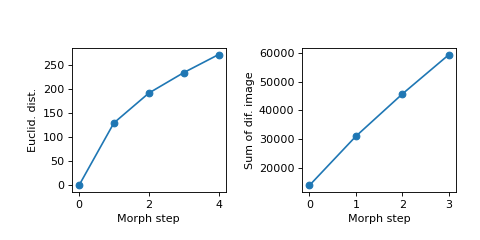

In [56]:
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
ax.plot(morphsteps, [diffs[v] for v in morphsteps], marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Euclid. dist.')

ax=axn[1]
ax.plot(d, marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Sum of dif. image')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, wspace=0.5, top=0.8)


In [620]:
diffs

{1: 129.56948852539062,
 2: 191.359619140625,
 3: 233.80543518066406,
 4: 271.2908630371094}

In [625]:
np.linalg.norm(im2-im1)

271.29086

<IPython.core.display.Javascript object>


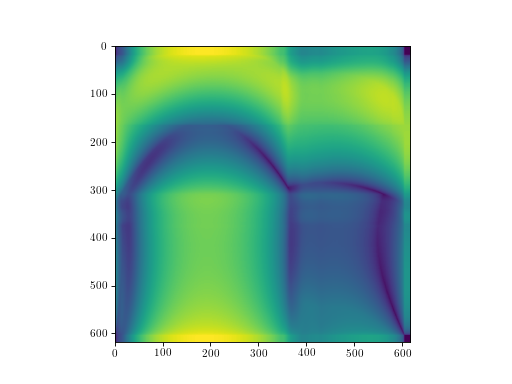

In [630]:
d1 = sp.spatial.distance.cdist(im2, im1, 'euclidean')
pl.figure()
pl.imshow(d1)

In [636]:
np.sum(diff_im)


-59371.383

In [343]:
pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T


threshold     width        lambda  gamma           eta
217   0.807907  0.688368  1.084300e-09    0.5  2.040462e-07

In [323]:
rid = 217

auc_r = best_auc[(best_auc['cell']==rid)].copy()
data = data_matrix_from_auc(auc_r)
data

array([[ 0.        , 14.        , 30.        ],
       [ 0.13207547, 17.        , 30.        ],
       [ 0.25471698, 18.        , 30.        ],
       [ 0.37735849, 15.        , 30.        ],
       [ 0.5       , 18.        , 30.        ],
       [ 0.62264151, 17.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 23.        , 30.        ],
       [ 1.        , 28.        , 30.        ]])

In [353]:
ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


0.807906798155016

In [357]:
ps.getSlope(res, ps.getThreshold(res, 0.75)[0])

0.9532720278663362

<IPython.core.display.Javascript object>


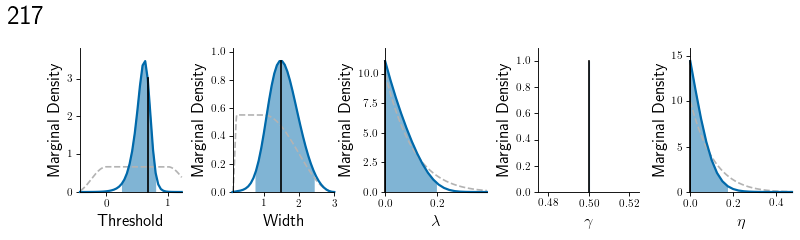

Error: The parameter you wanted to plot was fixed in the analysis!


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:324: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  plt.xlim([min(x), max(x)])


Text(0.01, 0.9, '217')

In [34]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

# figname = 'marginals_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


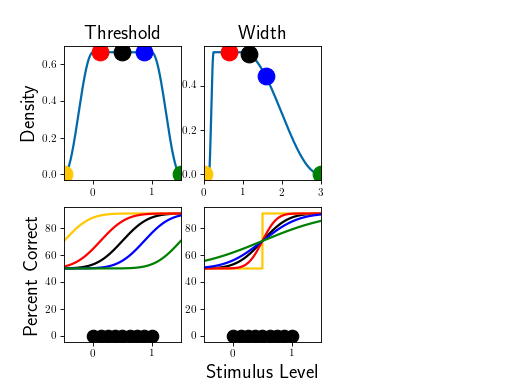

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [250]:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(res) #,axisHandle=ax)